# Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals

This notebook demonstrates the workflow and the images generated in the paper "Application of Deep Learning to Predict Persistence, Bioaccumulation and Toxicity of Pharmaceuticals". It also contains the generation of the substructures believed to be responsible for PBT behaviour obtained from the Deep Learning (DL) prediction model.

## Environment Setup

To execute this notebook, activate the main conda environment in a new bash shell:

```bash
conda activate main_DE
```

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit import DataStructs
from rdkit.Chem import Fragments, rdMolDescriptors, rdchem, MCS, rdFingerprintGenerator, Descriptors
from rdkit.ML.Cluster import Butina

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Local imports
from chem_utils import neutralize_atoms, get_largest_frag


/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from ipykernel import kernelapp as app


## Dataset collection 

In this section we will collect different datasets from different sources in order to build our compiled dataset. The final dataset will be then sanitized with a standardized procedure described above (***Filtering and Pre-Processing Procedure***) to obtain the **valid_df_PBT** with 5130 compounds (2710 labelled as PBT and 2420 as non-PBT)

Data is sourced from:

* Chemicals from European Chemicals Agency ECHA-PBT vPvB assessment under the previous EU chemicals legislation
* ECHA-registered substances
* ECHA PBT assessment list
* ECHA list of substances subject to POPs regulation
* Stockholm Convention of POPs 
* European databases SMILECAS, EINECS and ELINCS.

### Potential PBT chemicals identified by Strempel et al

In [196]:
Stremper_et_al = pd.read_csv('Compiled_dataset/Strempel_etal_PBTcompounds.csv')
Stremper_et_al

,CAS,R,SMILES,PBT_label
0,50-29-3,pr,Clc1ccc(cc1)C(c1ccc(Cl)cc1)C(Cl)(Cl)Cl,1
1,50-41-9,pr,CCN(CC)CCOc1ccc(cc1)C(=C(Cl)c1ccccc1)c1ccccc1,1
2,50-52-2,pr,CSc1ccc2Sc3ccccc3N(CCC3CCCCN3C)c2c1,1
3,53-19-0,pr,Clc1ccc(cc1)C(C(Cl)Cl)c1ccccc1Cl,1
4,53-69-0,pr,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,1
...,...,...,...,...
2780,187348-02-3,n,ClCC12C(Cl)C(Cl)C(CC1(Cl)Cl)C2(CCl)C(Cl)Cl,1
2781,189084-62-6,n,Brc1cccc(Br)c1Oc1ccc(Br)c(Br)c1,1
2782,190383-43-8,n,CCC(Cc1ccccc1)c1cc(O)c(c(=O)o1)C(C1CC1)c1cccc(...,1
2783,226256-56-0,n,C[C@H](NCCCc1cccc(c1)C(F)(F)F)c1cccc2ccccc12,1


### Expert-verified PBT chemicals from the European Chemicals Agency (ECHA) PBT/vPvB assessments

In [3]:
ECHA_expert_verified = pd.read_csv('Compiled_dataset/expert-verified_PBT_chemicals_ECHA.csv')
ECHA_expert_verified

,SMILES,Source,PBT_label
0,c1ccc(-c2cccc(-c3ccccc3)c2)cc1,https://echa.europa.eu/pbt,1
1,O=S(=O)(c1ccc(Cl)cc1)c1ccc(Cl)cc1,https://echa.europa.eu/pbt,1
2,COc1ccc(C(c2ccc(OC)cc2)C(Cl)(Cl)Cl)cc1,https://echa.europa.eu/pbt,1
3,c1cc2ccc3cccc4ccc(c1)c2c34,https://echa.europa.eu/pbt,1
4,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,https://echa.europa.eu/pbt,1
...,...,...,...
76,N.O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,https://echa.europa.eu/pbt,1
77,O=C1OC(=O)c2c(Br)c(Br)c(Br)c(Br)c21,https://echa.europa.eu/pbt,0
78,O=C([O-])C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,https://echa.europa.eu/pbt,1
79,c1ccc2c(c1)-c1cccc3cccc-2c13,https://echa.europa.eu/pbt,1


### ECHA PBT assessment list

In [4]:
ECHA_PBT_assessment_list = pd.read_csv('Compiled_dataset/ECHA_PBT_assessment_list.csv')
ECHA_PBT_assessment_list

,SMILES,Source,PBT_label
0,Cc1ccc2ccccc2c1,https://echa.europa.eu/information-on-chemical...,0
1,O=[N+]([O-])c1ccc(Oc2ccc(Cl)cc2Cl)cc1,https://echa.europa.eu/information-on-chemical...,1
2,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,https://echa.europa.eu/information-on-chemical...,1
3,C[Pb](C)(C)C,https://echa.europa.eu/information-on-chemical...,1
4,Clc1ccc(C(Cl)(Cl)Cl)cc1,https://echa.europa.eu/information-on-chemical...,0
...,...,...,...
59,CCCCCCCCCCCCCCCCCCOC(=O)CCc1cc(C(C)(C)C)c(O)c(...,https://echa.europa.eu/information-on-chemical...,0
60,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,https://echa.europa.eu/information-on-chemical...,0
61,CCCCCCCCCCCCCCCS(=O)(=O)Oc1ccccc1,https://echa.europa.eu/information-on-chemical...,0
62,CC[Pb](CC)(CC)CC,https://echa.europa.eu/information-on-chemical...,0


### The ECHA list of substances subject to POP Regulation

In [5]:
ECHA_POP_regulation = pd.read_csv('Compiled_dataset/ECHA_substances_POP_Regulation.csv')
ECHA_POP_regulation

,SMILES,Source,PBT_label
0,Br[C@H]1CC[C@@H](Br)[C@H](Br)CC[C@@H](Br)[C@@H...,https://www.echa.europa.eu/list-of-substances-...,1
1,Br[C@H]1CC[C@H](Br)[C@H](Br)CC[C@@H](Br)[C@H](...,https://www.echa.europa.eu/list-of-substances-...,1
2,Brc1cc(Br)c(Oc2ccc(Br)c(Br)c2Br)cc1Br,https://www.echa.europa.eu/list-of-substances-...,1
3,Brc1cc(Br)c(Oc2ccc(Br)c(Br)c2)c(Br)c1,https://www.echa.europa.eu/list-of-substances-...,1
4,Brc1ccc(Oc2ccc(Br)c(Br)c2Br)c(Br)c1,https://www.echa.europa.eu/list-of-substances-...,1
...,...,...,...
213,O=C([O-])C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(C(F)...,https://www.echa.europa.eu/list-of-substances-...,1
214,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,https://www.echa.europa.eu/list-of-substances-...,1
215,c1ccc2c(c1)-c1cccc3c1c-2cc1ccccc13,https://www.echa.europa.eu/list-of-substances-...,1
216,O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,https://www.echa.europa.eu/list-of-substances-...,1


### The new POP list under the Stockholm Convention

In [6]:
POP_list_stockolm = pd.read_csv('Compiled_dataset/new POP list under the Stockholm Convention.csv')
POP_list_stockolm

,SMILES,Source,PBT_label
0,CCCC(Cl)CCCC(Cl)CCC(Cl)CCC(Cl)CCC(Cl)CCCC(Cl)CCC,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
1,CCCC(Cl)CCC(Cl)CC(Cl)C(Cl)CCC(Cl)CCC(Cl)C(Cl)C...,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
2,COc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
3,CC(Cl)CCCC(Cl)CCCC(Cl)CCCC(Cl)CCCC(Cl)CCCC(Cl)...,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
4,CCCCCCCCCCCC(=O)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
5,O.[Na+].[O-]c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
6,[Na+].[O-]c1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
7,CCC(Cl)C(Cl)C(Cl)CC(Cl)C(Cl)C(C)Cl,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
8,Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)c(Br)c1,http://www.pops.int/TheConvention/ThePOPs/TheN...,1
9,Brc1cc(Br)c(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,http://www.pops.int/TheConvention/ThePOPs/TheN...,1


In [7]:
len(POP_list_stockolm)

37

### ECHA-registered substances

In [8]:
ECHA_reg_substances = pd.read_csv('Compiled_dataset/ECHA-registered_substances.csv')
ECHA_reg_substances

,SMILES,Source,PBT_label
0,CC1(C)[C@@H]2CC[C@@]1(C)C(=O)C2,https://echa.europa.eu/information-on-chemical...,0
1,Cl.NC(N)=NCCC[C@H](N)C(=O)O,https://echa.europa.eu/information-on-chemical...,0
2,O=C(O)[C@H](O)[C@@H](O)C(=O)O,https://echa.europa.eu/information-on-chemical...,0
3,O=C(O)[C@@H](O)[C@H](O)C(=O)O,https://echa.europa.eu/information-on-chemical...,0
4,CC1=CCC(/C=C/C(C)(C)C(C)O)C1(C)C,https://echa.europa.eu/information-on-chemical...,0
...,...,...,...
2882,CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](O)C2,https://echa.europa.eu/information-on-chemical...,0
2883,CC1(C)[C@@H]2CC[C@]1(C)[C@H](O)C2,https://echa.europa.eu/information-on-chemical...,0
2884,CC1(C)C2CC[C@]1(C)C(O)C2,https://echa.europa.eu/information-on-chemical...,0
2885,CC1(C)[C@@H]2CC[C@@]1(C)[C@H](O)C2,https://echa.europa.eu/information-on-chemical...,0


In [9]:
data_concat = pd.concat([Stremper_et_al, ECHA_expert_verified, ECHA_PBT_assessment_list, ECHA_POP_regulation, POP_list_stockolm, ECHA_reg_substances], ignore_index=True)
data_concat

,CAS,R,SMILES,PBT_label,Source
0,50-29-3,pr,Clc1ccc(cc1)C(c1ccc(Cl)cc1)C(Cl)(Cl)Cl,1,NaN
1,50-41-9,pr,CCN(CC)CCOc1ccc(cc1)C(=C(Cl)c1ccccc1)c1ccccc1,1,NaN
2,50-52-2,pr,CSc1ccc2Sc3ccccc3N(CCC3CCCCN3C)c2c1,1,NaN
3,53-19-0,pr,Clc1ccc(cc1)C(C(Cl)Cl)c1ccccc1Cl,1,NaN
4,53-69-0,pr,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,1,NaN
...,...,...,...,...,...
6067,NaN,NaN,CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](O)C2,0,https://echa.europa.eu/information-on-chemical...
6068,NaN,NaN,CC1(C)[C@@H]2CC[C@]1(C)[C@H](O)C2,0,https://echa.europa.eu/information-on-chemical...
6069,NaN,NaN,CC1(C)C2CC[C@]1(C)C(O)C2,0,https://echa.europa.eu/information-on-chemical...
6070,NaN,NaN,CC1(C)[C@@H]2CC[C@@]1(C)[C@H](O)C2,0,https://echa.europa.eu/information-on-chemical...


In [10]:
data_PBT_concat= data_concat.drop(['Source', 'CAS', 'R'], axis= 1)
data_PBT_concat

,SMILES,PBT_label
0,Clc1ccc(cc1)C(c1ccc(Cl)cc1)C(Cl)(Cl)Cl,1
1,CCN(CC)CCOc1ccc(cc1)C(=C(Cl)c1ccccc1)c1ccccc1,1
2,CSc1ccc2Sc3ccccc3N(CCC3CCCCN3C)c2c1,1
3,Clc1ccc(cc1)C(C(Cl)Cl)c1ccccc1Cl,1
4,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,1
...,...,...
6067,CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](O)C2,0
6068,CC1(C)[C@@H]2CC[C@]1(C)[C@H](O)C2,0
6069,CC1(C)C2CC[C@]1(C)C(O)C2,0
6070,CC1(C)[C@@H]2CC[C@@]1(C)[C@H](O)C2,0


## **Filtering and Pre-Processing Procedure**

The following steps have been applied to the `data_PBT_concat` dataset to standardize and filter molecules. These steps should be repeated for any other datasets, such as `agrochemicals` and `DrugBank_data`.

1. **Convert SMILES to Molecules**: 
   - Each SMILES string is converted to an RDKit molecule object using `Chem.MolFromSmiles`.
   
2. **Standardization**:
   - **Largest Fragment**: Only the largest fragment in each molecule is retained, using the `get_largest_frag` function.
   - **Neutralization**: Each molecule is neutralized by adjusting formal charges with the `neutralize_atoms` function.
   - **Canonical SMILES**: A canonical SMILES representation (`comparator_smiles`) is generated for each standardized molecule.

3. **Duplicate Identification**:
   - Identify and group duplicated molecules based on their `comparator_smiles` values. 
   - For each group of duplicates, create pairs of SMILES strings and their corresponding standardized versions along with their labels (`PBT_label`).

4. **Consistency Filtering**:
   - For each unique standardized SMILES in the pairs, check if all labels in the group are consistent. 
   - If the labels are consistent (i.e., they all share the same `PBT_label`), keep this standardized SMILES with its label.

5. **Data Filtering**:
   - Remove any entries from the original dataset that match the standardized SMILES kept in the previous step.
   - Combine the consistent standardized SMILES and labels with the filtered dataset to create a final, standardized dataset.

6. **Deduplication**:
   - Remove any duplicate rows in the standardized dataset to ensure each molecule is unique.

7. **Validity Check**:
   - Define a function to check if each SMILES can be converted to a valid molecule.
   - Filter the dataset to keep only rows where the standardized SMILES can be successfully converted to valid molecule objects.

The resulting dataset will contain unique, valid, and standardized SMILES with consistent labels.


1. **Convert SMILES to Molecules**
2. **Standardization**

In [11]:
# 1. Convert SMILES to RDKit molecules
data_PBT_concat['mol'] = data_PBT_concat['SMILES'].apply(Chem.MolFromSmiles)
# 2. Get the largest fragment
data_PBT_concat['mol_no-mc'] = data_PBT_concat['mol'].apply(get_largest_frag)
# 3. Neutralize molecules
data_PBT_concat['mol_no-mc-neutral'] = data_PBT_concat['mol_no-mc'].apply(neutralize_atoms)
# 4. Canonicalize everything to a new SMILES column
data_PBT_concat['comparator_smiles'] = data_PBT_concat['mol_no-mc-neutral'].apply(
    lambda mol: Chem.MolToSmiles(mol) if mol else None)

data_PBT_concat.head()

[19:03:26] Can't kekulize mol.  Unkekulized atoms: 9 10 11
[19:03:26] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:03:26] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:03:26] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:03:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9
[19:03:27] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:03:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:03:27] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:03:27] Explicit valence for atom # 8 O, 3, is greater than permitted
[19:03:27] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:03:27] Explicit valence for atom # 22 O, 3, is greater than permitted
[19:03:27] Can't kekulize mol.  Unkekulized atoms: 17 19 20 21 22 23 24
[19:03:27] Explicit valence for atom # 11 O, 3, is greater than permitted
[19:03:27] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 12 1

,SMILES,PBT_label,mol,mol_no-mc,mol_no-mc-neutral,comparator_smiles
0,Clc1ccc(cc1)C(c1ccc(Cl)cc1)C(Cl)(Cl)Cl,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fdbdb0>,<rdkit.Chem.rdchem.Mol object at 0x7f423105fe10>,<rdkit.Chem.rdchem.Mol object at 0x7f423105fe10>,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
1,CCN(CC)CCOc1ccc(cc1)C(=C(Cl)c1ccccc1)c1ccccc1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8990>,<rdkit.Chem.rdchem.Mol object at 0x7f4230fdbd50>,<rdkit.Chem.rdchem.Mol object at 0x7f4230fdbd50>,CCN(CC)CCOc1ccc(C(=C(Cl)c2ccccc2)c2ccccc2)cc1
2,CSc1ccc2Sc3ccccc3N(CCC3CCCCN3C)c2c1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe87b0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230fdb210>,<rdkit.Chem.rdchem.Mol object at 0x7f4230fdb210>,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2
3,Clc1ccc(cc1)C(C(Cl)Cl)c1ccccc1Cl,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8450>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00390>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00390>,Clc1ccc(C(c2ccccc2Cl)C(Cl)Cl)cc1
4,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8330>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00510>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00510>,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1


3. **Duplicate Identification**

In [12]:
df = data_PBT_concat[data_PBT_concat.duplicated(keep=False, subset=['comparator_smiles'])]

pair_list = df.groupby(by=['comparator_smiles']).apply(lambda x: tuple(x.index))
pair_list = pair_list.tolist()
print(pair_list)

[(4777, 5938), (549, 2930, 2931, 3165), (2683, 2684), (1364, 1758), (3157, 3167), (3161, 3171), (3156, 3166), (3158, 3168), (2933, 3130), (3162, 3172), (2932, 3129), (2877, 2889), (806, 2695), (3159, 3169), (3164, 3174), (3061, 3132), (2781, 3062, 3133), (3064, 3135), (3063, 3134), (2934, 3131), (3163, 3173), (335, 368), (3160, 3170), (3583, 5898), (145, 880), (2798, 2843), (2879, 2913), (3281, 6006), (4990, 6014), (3544, 5887), (5412, 5413), (627, 2967, 3098), (3615, 5903), (3031, 3108), (3032, 3109), (3008, 3106), (3009, 3107), (3048, 3101), (449, 4067, 5876), (3939, 4023, 6050), (205, 766), (3662, 5997), (3326, 6016), (4022, 6059), (4020, 4521), (4520, 5700), (3050, 3117), (3049, 3116), (3033, 3120), (3026, 3119), (3007, 3118), (1180, 2482, 2966, 3110), (907, 4066, 5867), (2814, 2842), (252, 363), (1252, 3038, 3097), (4064, 5866), (394, 613), (215, 604), (4250, 6008), (3373, 6053), (4190, 4191), (3826, 3966), (3925, 3926), (4197, 4198), (4746, 4747, 4748, 4927, 5333), (4749, 4901), 

In [13]:
len(pair_list)

593

4. **Consistency Filtering**:

In [14]:
pairs_dicts = []

for pair in pair_list:
    # Iterate over each element in the tuple
    for i in range(len(pair)):
        for j in range(i + 1, len(pair)):
            # Create pairs from the tuple
            i1, i2 = pair[i], pair[j]
            d = {
                'smi1_original': df.loc[i1]['SMILES'],
                'smi2_original': df.loc[i2]['SMILES'],
                'smi1_standardized': Chem.MolToSmiles(Chem.MolFromSmiles(df.loc[i1]['comparator_smiles'])),
                'smi2_standardized': Chem.MolToSmiles(Chem.MolFromSmiles(df.loc[i2]['comparator_smiles'])),
                'label_1': df.loc[i1]['PBT_label'],
                'label_2': df.loc[i2]['PBT_label'],
            }
            pairs_dicts.append(d)

# Create a DataFrame from the list of dictionaries and save it as a CSV file
pd.DataFrame(pairs_dicts).to_csv('pair_comparisons_newdataPBT.csv', index=False)

In [15]:
pairs = pd.read_csv('pair_comparisons_newdataPBT.csv')
pairs

,smi1_original,smi2_original,smi1_standardized,smi2_standardized,label_1,label_2
0,BrC(Br)Br,BrC(Br)Br,BrC(Br)Br,BrC(Br)Br,0,0
1,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,Br[C@H]1CC[C@@H](Br)[C@H](Br)CC[C@@H](Br)[C@@H...,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,1,1
2,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,Br[C@H]1CC[C@H](Br)[C@H](Br)CC[C@@H](Br)[C@H](...,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,1,1
3,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,Br[C@H]1CC[C@@H](Br)[C@H](Br)CC[C@H](Br)[C@H](...,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,1,1
4,Br[C@H]1CC[C@@H](Br)[C@H](Br)CC[C@@H](Br)[C@@H...,Br[C@H]1CC[C@H](Br)[C@H](Br)CC[C@@H](Br)[C@H](...,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,BrC1CCC(Br)C(Br)CCC(Br)C(Br)CCC1Br,1,1
...,...,...,...,...,...,...
2008,c1ccc2cc3c(cc2c1)c1cccc2cccc3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,1,1
2009,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12,1,1
2010,c1ccc2cc3c(cc2c1)c1ccccc1c1ccccc31,c1ccc2cc3c(cc2c1)c1ccccc1c1ccccc31,c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1,c1ccc2cc3c4ccccc4c4ccccc4c3cc2c1,1,1
2011,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,c1ccc2sc(SN(C3CCCCC3)C3CCCCC3)nc2c1,1,1


In [16]:
unique_smis = list(set(pairs['smi1_standardized']))
keep = {}
for smi in unique_smis:
    rows = pairs[pairs['smi1_standardized']==smi]
    labels = list(rows['label_1']) + list(rows['label_2'])
    if len(set(labels)) <= 1:
        keep[smi] = labels[0]

In [17]:
len(unique_smis)

593

In [18]:
# Assuming standardized_smiles_data is your standardized SMILES data
data_PBT_concat['standardized_smiles'] = data_PBT_concat['comparator_smiles']

In [19]:
data_PBT_concat = data_PBT_concat[~data_PBT_concat['standardized_smiles'].isin(unique_smis)]
data_PBT_concat

,SMILES,PBT_label,mol,mol_no-mc,mol_no-mc-neutral,comparator_smiles,standardized_smiles
4,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8330>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00510>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00510>,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1,Cc1cc(C)c2nc3ccc4ccccc4c3cc2c1
5,c1ccc2ccc3cc4c(ccc5ccccc45)cc3c2c1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8750>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00450>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00450>,c1ccc2c(c1)ccc1cc3c(ccc4ccccc43)cc12,c1ccc2c(c1)ccc1cc3c(ccc4ccccc43)cc12
6,Cc1ccc2cc3c4ccccc4ccc3c3CCc1c23,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8930>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f003f0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f003f0>,Cc1ccc2cc3c(ccc4ccccc43)c3c2c1CC3,Cc1ccc2cc3c(ccc4ccccc43)c3c2c1CC3
9,O=C(CCC1CCCC1)OC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8270>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00330>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f00330>,CC12CCC(=O)C=C1CCC1C2CCC2(C)C(OC(=O)CCC3CCCC3)...,CC12CCC(=O)C=C1CCC1C2CCC2(C)C(OC(=O)CCC3CCCC3)...
10,CCN(CC)CCN1c2ccccc2Sc2ccc(Cl)cc12,1,<rdkit.Chem.rdchem.Mol object at 0x7f4230fe8c30>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f002d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230f002d0>,CCN(CC)CCN1c2ccccc2Sc2ccc(Cl)cc21,CCN(CC)CCN1c2ccccc2Sc2ccc(Cl)cc21
...,...,...,...,...,...,...,...
5860,CN(C)CCCN(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79c90>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e870>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e870>,CN(C)CCCN(C)C,CN(C)CCCN(C)C
5861,C[N+](C)(C)C1CCCCC1.[OH-],0,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79cf0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e8d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e8d0>,C[N+](C)(C)C1CCCCC1,C[N+](C)(C)C1CCCCC1
5862,c1ccc(N(CC2CO2)CC2CO2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79d50>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e930>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e930>,c1ccc(N(CC2CO2)CC2CO2)cc1,c1ccc(N(CC2CO2)CC2CO2)cc1
5863,CCCCCCCCCCCC(=O)N(CCO)CCO,0,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79db0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e990>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e990>,CCCCCCCCCCCC(=O)N(CCO)CCO,CCCCCCCCCCCC(=O)N(CCO)CCO


5. **Data Filtering**:

In [20]:
#add the things from keep dict to it
starting_PBTdat = pd.concat([pd.DataFrame([{'standardized_smiles':k, 'PBT_label':v} for k,v in keep.items()]), data_PBT_concat])
starting_PBTdat

,standardized_smiles,PBT_label,SMILES,mol,mol_no-mc,mol_no-mc-neutral,comparator_smiles
0,CCc1cc2ccc3ccccc3c2c2ccccc12,1,NaN,NaN,NaN,NaN,NaN
1,ClC(Cl)(Cl)Cl,0,NaN,NaN,NaN,NaN,NaN
2,O=C1c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C(=O)N1c1c...,0,NaN,NaN,NaN,NaN,NaN
3,Brc1ccccc1Oc1c(Br)c(Br)c(Br)c(Br)c1Br,1,NaN,NaN,NaN,NaN,NaN
4,CC(C)=CCCC(C)=CCCC(C)=CCO,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5860,CN(C)CCCN(C)C,0,CN(C)CCCN(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79c90>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e870>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e870>,CN(C)CCCN(C)C
5861,C[N+](C)(C)C1CCCCC1,0,C[N+](C)(C)C1CCCCC1.[OH-],<rdkit.Chem.rdchem.Mol object at 0x7f4230f79cf0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e8d0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e8d0>,C[N+](C)(C)C1CCCCC1
5862,c1ccc(N(CC2CO2)CC2CO2)cc1,0,c1ccc(N(CC2CO2)CC2CO2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79d50>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e930>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e930>,c1ccc(N(CC2CO2)CC2CO2)cc1
5863,CCCCCCCCCCCC(=O)N(CCO)CCO,0,CCCCCCCCCCCC(=O)N(CCO)CCO,<rdkit.Chem.rdchem.Mol object at 0x7f4230f79db0>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e990>,<rdkit.Chem.rdchem.Mol object at 0x7f4230e8e990>,CCCCCCCCCCCC(=O)N(CCO)CCO


In [21]:
starting_PBT = starting_PBTdat.iloc[:, :2]
starting_PBT

,standardized_smiles,PBT_label
0,CCc1cc2ccc3ccccc3c2c2ccccc12,1
1,ClC(Cl)(Cl)Cl,0
2,O=C1c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C(=O)N1c1c...,0
3,Brc1ccccc1Oc1c(Br)c(Br)c(Br)c(Br)c1Br,1
4,CC(C)=CCCC(C)=CCCC(C)=CCO,0
...,...,...
5860,CN(C)CCCN(C)C,0
5861,C[N+](C)(C)C1CCCCC1,0
5862,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5863,CCCCCCCCCCCC(=O)N(CCO)CCO,0


6. **Deduplication**:

In [22]:
starting_PBT = starting_PBT.drop_duplicates()
starting_PBT

,standardized_smiles,PBT_label
0,CCc1cc2ccc3ccccc3c2c2ccccc12,1
1,ClC(Cl)(Cl)Cl,0
2,O=C1c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C(=O)N1c1c...,0
3,Brc1ccccc1Oc1c(Br)c(Br)c(Br)c(Br)c1Br,1
4,CC(C)=CCCC(C)=CCCC(C)=CCO,0
...,...,...
5860,CN(C)CCCN(C)C,0
5861,C[N+](C)(C)C1CCCCC1,0
5862,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5863,CCCCCCCCCCCC(=O)N(CCO)CCO,0


7. **Validity Check**:

In [23]:
# Define the to_mol function to convert SMILES to molecule
def to_mol(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except:
        return None

valid_df_PBT = starting_PBT[starting_PBT["standardized_smiles"].apply(lambda smi: to_mol(smi) is not None)]
valid_df_PBT.reset_index(drop=True, inplace=True)
valid_df_PBT

[19:03:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:03:35] Explicit valence for atom # 4 B, 5, is greater than permitted
[19:03:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[19:03:35] Explicit valence for atom # 3 B, 5, is greater than permitted
[19:03:35] Explicit valence for atom # 1 B, 5, is greater than permitted


,standardized_smiles,PBT_label
0,CCc1cc2ccc3ccccc3c2c2ccccc12,1
1,ClC(Cl)(Cl)Cl,0
2,O=C1c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C(=O)N1c1c...,0
3,Brc1ccccc1Oc1c(Br)c(Br)c(Br)c(Br)c1Br,1
4,CC(C)=CCCC(C)=CCCC(C)=CCO,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [24]:
#valid_df_PBT.to_csv('Datasets/5130compounds_PBT.csv', Index = False)

## Figure 2: tSNE plots comparing Molecular features 

In the following section we will examine the distribution of the compounds in our compiled dataset (labelled as PBT and non-PBT) in a chemical space described by 13 molecular features and investigated its applicability domain using t-Distributed Stochastic Neighbor Embedding (t-SNE) plots (Figure 2).

t-SNE plots representing high-dimensional molecular data in two dimensions with 13 molecular features mapping: A) the compiled dataset, with PBT (orange) and non-PBT (green) chemicals highlighted in different colors, B) overlap between the compiled (gray) and Agrochemicals(yellow) datasets, and C) overlap between the compiled dataset (gray) and  DrugBank data (pink) in the defined chemical space.

### PBT labelled dataset

In [25]:
startPBT_correct = pd.read_csv('Datasets/5130compounds_PBT.csv')
startPBT_correct.columns = ['SMILES', 'PBT_label']
startPBT_correct

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [26]:
counts = startPBT_correct['PBT_label'].value_counts()
counts

1    2710
0    2420
Name: PBT_label, dtype: int64

### **Agrochemicals** 

In [27]:
agrochemicals = pd.read_csv('Datasets/agrochemicals_sanitized.csv')
agrochemicals

,Name,standardized_smiles
0,(4-chlorophenoxy)acetic acid,O=C(O)COc1ccc(Cl)cc1
1,"1-(4-chloro-1,3-dihydro-1,3-dioxo-2H-isoindole...",NC(=O)C1(N2C(=O)c3cccc(Cl)c3C2=O)CCCCC1
2,"1-(4-chlorophenyl)-3-(2,6-dichlorobenzoyl)urea",O=C(NC(=O)c1c(Cl)cccc1Cl)Nc1ccc(Cl)cc1
3,"1,1,1,2-tetrachloroethane",ClCC(Cl)(Cl)Cl
4,"1,1,1-trichloroethane",CC(Cl)(Cl)Cl
...,...,...
1272,Xylachlor,Cc1cccc(N(C(=O)CCl)C(C)C)c1C
1273,Xylylcarb,CNC(=O)Oc1ccc(C)c(C)c1
1274,Zarilamid,CCOC(C#N)NC(=O)c1ccc(Cl)cc1
1275,Zinc phosphide,P=[Zn]


### **DrugBank**

In [28]:
DrugBank_data = pd.read_csv('Datasets/drugs_DrugBank_sanitized.csv')
DrugBank_data

,GENERIC_NAME,standardized_smiles
0,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...
1,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=...
2,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
3,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
4,Desmopressin,N=C(N)NCCC[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]...
...,...,...
11163,Alogabat,Cc1ccc(-c2noc(C)c2COc2ccc(C(=O)NC3CCOCC3)nn2)cn1
11164,Ropsacitinib,Cn1cc(-c2cn3nccc3c(-c3cnn([C@]4(CC#N)C[C@@H](C...
11165,taletrectinib,C[C@@H](N)COc1ccc(-c2cnc3ccc(N[C@H](C)c4cccc(F...
11166,Tolebrutinib,C=CC(=O)N1CCC[C@@H](n2c(=O)n(-c3ccc(Oc4ccccc4)...


In [29]:
mols_PBT = [rdkit.Chem.MolFromSmiles(smi) for smi in startPBT_correct['SMILES']]

In [30]:
mols_agro =  [rdkit.Chem.MolFromSmiles(smi) for smi in agrochemicals['standardized_smiles']]

In [31]:
mols_DrugBank = [rdkit.Chem.MolFromSmiles(smi) for smi in DrugBank_data['standardized_smiles']]

### Workflow to generate tSNE plots

The following steps explore the chemical space of three distinct molecular datasets using **13 RDKit descriptors** and dimensionality reduction techniques:

1. **Generated 13 molecular descriptors** using RDKit for:
   - **PBT dataset** (PBT and non-PBT molecules)
   - **Agrochemicals**
   - **DrugBank**
   
2. **Standardized features** using MinMaxScaler

3. Created **t-SNE visualizations** showing:
   - Distribution of **PBT** vs **non-PBT** molecules in chemical space
   - Overlap between our compiled dataset (**gray**) and Agrochemicals (**yellow**)
   - Overlap between our compiled dataset (**gray**) and DrugBank data (**pink**)

1. **Generated 13 molecular descriptors for our compiled dataset**

In [32]:
features_PBT=pd.DataFrame()
for i,mol in enumerate(mols_PBT):
    features_PBT.loc[i,'MolWt']=Descriptors.MolWt(mol)
    features_PBT.loc[i,'HBA']=rdMolDescriptors.CalcNumLipinskiHBA(mol)
    features_PBT.loc[i,'HBD']= rdMolDescriptors.CalcNumLipinskiHBD(mol)
    features_PBT.loc[i,'NumRotafeaturescBonds']=Descriptors.NumRotatableBonds(mol)
    features_PBT.loc[i,'NumHalogens']=Fragments.fr_halogen(mol)
    features_PBT.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    features_PBT.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
    features_PBT.loc[i,'RingCount']=Descriptors.RingCount(mol)
    features_PBT.loc[i,'TPSA']=Descriptors.TPSA(mol)
    features_PBT.loc[i,'Stereocenters']=rdkit.Chem.rdMolDescriptors.CalcNumAtomStereoCenters(mol)
    features_PBT.loc[i,'NumArR']=Descriptors.NumAromaticRings(mol)
    features_PBT.loc[i,'NumAliR']=Descriptors.NumAliphaticRings(mol)
    features_PBT.loc[i,'logP']=Descriptors.MolLogP(mol)

In [33]:
features_PBT

,MolWt,HBA,HBD,NumRotafeaturescBonds,NumHalogens,NumHeteroatoms,FractionCSP3,RingCount,TPSA,Stereocenters,NumArR,NumAliR,logP
0,596.117,1.0,0.0,20.0,0.0,3.0,1.000000,0.0,9.23,0.0,0.0,0.0,9.69460
1,104.080,2.0,0.0,1.0,1.0,3.0,0.250000,0.0,26.30,0.0,0.0,0.0,0.64260
2,264.366,0.0,0.0,0.0,5.0,5.0,0.142857,1.0,0.00,0.0,1.0,0.0,5.26202
3,198.052,1.0,0.0,0.0,2.0,3.0,0.000000,2.0,12.89,0.0,2.0,0.0,3.54160
4,167.258,1.0,1.0,0.0,0.0,3.0,0.000000,2.0,15.79,0.0,2.0,0.0,2.95889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5125,130.235,2.0,0.0,4.0,0.0,2.0,1.000000,0.0,6.48,0.0,0.0,0.0,0.49970
5126,142.266,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.00,0.0,0.0,1.0,2.02530
5127,205.257,3.0,0.0,5.0,0.0,3.0,0.500000,3.0,28.30,2.0,1.0,2.0,1.29060
5128,287.444,4.0,2.0,14.0,0.0,4.0,0.937500,0.0,60.77,0.0,0.0,0.0,2.72050


1. **Generated 13 molecular descriptors for Agrochemicals**

In [34]:
features_agro =pd.DataFrame()
for i,mol in enumerate(mols_agro):
    features_agro.loc[i,'MolWt']=Descriptors.MolWt(mol)
    features_agro.loc[i,'HBA']=rdMolDescriptors.CalcNumLipinskiHBA(mol)
    features_agro.loc[i,'HBD']= rdMolDescriptors.CalcNumLipinskiHBD(mol)
    features_agro.loc[i,'NumRotafeaturescBonds']=Descriptors.NumRotatableBonds(mol)
    features_agro.loc[i,'NumHalogens']=Fragments.fr_halogen(mol)
    features_agro.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    features_agro.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
    features_agro.loc[i,'RingCount']=Descriptors.RingCount(mol)
    features_agro.loc[i,'TPSA']=Descriptors.TPSA(mol)
    features_agro.loc[i,'Stereocenters']=rdkit.Chem.rdMolDescriptors.CalcNumAtomStereoCenters(mol)
    features_agro.loc[i,'NumArR']=Descriptors.NumAromaticRings(mol)
    features_agro.loc[i,'NumAliR']=Descriptors.NumAliphaticRings(mol)
    features_agro.loc[i,'logP']=Descriptors.MolLogP(mol)

In [35]:
features_agro

,MolWt,HBA,HBD,NumRotafeaturescBonds,NumHalogens,NumHeteroatoms,FractionCSP3,RingCount,TPSA,Stereocenters,NumArR,NumAliR,logP
0,186.594,3.0,1.0,3.0,1.0,4.0,0.125000,1.0,46.53,0.0,1.0,0.0,1.80340
1,306.749,5.0,2.0,2.0,1.0,6.0,0.400000,3.0,80.47,0.0,1.0,2.0,2.12420
2,343.597,4.0,2.0,2.0,3.0,7.0,0.000000,2.0,58.20,0.0,2.0,0.0,4.60870
3,167.850,0.0,0.0,0.0,4.0,4.0,1.000000,0.0,0.00,0.0,0.0,0.0,2.59540
4,133.405,0.0,0.0,0.0,3.0,3.0,1.000000,0.0,0.00,0.0,0.0,0.0,2.37650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,239.746,2.0,0.0,3.0,1.0,3.0,0.461538,1.0,20.31,0.0,1.0,0.0,3.28364
1273,179.219,3.0,1.0,1.0,0.0,3.0,0.300000,1.0,38.33,0.0,1.0,0.0,2.02164
1274,238.674,4.0,1.0,4.0,1.0,5.0,0.272727,1.0,62.12,1.0,1.0,0.0,1.95598
1275,97.372,0.0,0.0,0.0,0.0,2.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.59100


1. **Generated 13 molecular descriptors for DrugBank data**

In [36]:
features_DrugBank =pd.DataFrame()
for i,mol in enumerate(mols_DrugBank):
    features_DrugBank.loc[i,'MolWt']=Descriptors.MolWt(mol)
    features_DrugBank.loc[i,'HBA']=rdMolDescriptors.CalcNumLipinskiHBA(mol)
    features_DrugBank.loc[i,'HBD']= rdMolDescriptors.CalcNumLipinskiHBD(mol)
    features_DrugBank.loc[i,'NumRotafeaturescBonds']=Descriptors.NumRotatableBonds(mol)
    features_DrugBank.loc[i,'NumHalogens']=Fragments.fr_halogen(mol)
    features_DrugBank.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    features_DrugBank.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
    features_DrugBank.loc[i,'RingCount']=Descriptors.RingCount(mol)
    features_DrugBank.loc[i,'TPSA']=Descriptors.TPSA(mol)
    features_DrugBank.loc[i,'Stereocenters']=rdkit.Chem.rdMolDescriptors.CalcNumAtomStereoCenters(mol)
    features_DrugBank.loc[i,'NumArR']=Descriptors.NumAromaticRings(mol)
    features_DrugBank.loc[i,'NumAliR']=Descriptors.NumAliphaticRings(mol)
    features_DrugBank.loc[i,'logP']=Descriptors.MolLogP(mol)

In [37]:
features_DrugBank

,MolWt,HBA,HBD,NumRotafeaturescBonds,NumHalogens,NumHeteroatoms,FractionCSP3,RingCount,TPSA,Stereocenters,NumArR,NumAliR,logP
0,2180.317,57.0,31.0,66.0,0.0,57.0,0.540816,6.0,901.57,16.0,3.0,3.0,-8.11643
1,1209.421,28.0,17.0,32.0,0.0,28.0,0.525424,6.0,429.04,9.0,4.0,2.0,-1.22843
2,1269.433,32.0,20.0,31.0,0.0,32.0,0.508475,6.0,495.89,9.0,4.0,2.0,-3.10570
3,1811.253,35.0,20.0,51.0,0.0,35.0,0.510417,8.0,519.89,13.0,8.0,0.0,4.86760
4,1069.238,26.0,18.0,19.0,0.0,28.0,0.478261,4.0,435.41,7.0,2.0,2.0,-4.13203
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11163,409.446,9.0,1.0,6.0,0.0,9.0,0.380952,4.0,112.26,0.0,3.0,1.0,2.63124
11164,383.419,9.0,0.0,4.0,0.0,9.0,0.300000,5.0,113.41,0.0,4.0,1.0,2.53586
11165,405.477,6.0,3.0,7.0,1.0,7.0,0.217391,4.0,77.47,2.0,4.0,0.0,4.43450
11166,455.518,8.0,2.0,5.0,0.0,8.0,0.192308,5.0,95.38,1.0,4.0,1.0,3.91120


2. **Standardized features** using MinMaxScaler

In [38]:
features_PBT_scaled=pd.DataFrame(MinMaxScaler().fit_transform(features_PBT), columns=features_PBT.columns)

In [39]:
features_PBT_scaled

,MolWt,HBA,HBD,NumRotafeaturescBonds,NumHalogens,NumHeteroatoms,FractionCSP3,RingCount,TPSA,Stereocenters,NumArR,NumAliR,logP
0,0.362551,0.025,0.000000,0.303030,0.000000,0.054545,1.000000,0.000000,0.014577,0.00,0.000000,0.000000,0.620828
1,0.050300,0.050,0.000000,0.015152,0.019608,0.054545,0.250000,0.000000,0.041535,0.00,0.000000,0.000000,0.413465
2,0.152019,0.000,0.000000,0.000000,0.098039,0.090909,0.142857,0.033333,0.000000,0.00,0.071429,0.000000,0.519287
3,0.109935,0.025,0.000000,0.000000,0.039216,0.054545,0.000000,0.066667,0.020357,0.00,0.142857,0.000000,0.479875
4,0.090393,0.025,0.041667,0.000000,0.000000,0.054545,0.000000,0.066667,0.024937,0.00,0.142857,0.000000,0.466527
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5125,0.066898,0.050,0.000000,0.060606,0.000000,0.036364,1.000000,0.000000,0.010234,0.00,0.000000,0.000000,0.410192
5126,0.074533,0.025,0.000000,0.015152,0.000000,0.018182,1.000000,0.033333,0.000000,0.00,0.000000,0.033333,0.445140
5127,0.114508,0.075,0.000000,0.075758,0.000000,0.054545,0.500000,0.100000,0.044694,0.05,0.071429,0.066667,0.428310
5128,0.166664,0.100,0.083333,0.212121,0.000000,0.072727,0.937500,0.000000,0.095973,0.00,0.000000,0.000000,0.461066


3. Create **t-SNE plot for our compiled dataset hilighting PBT and non-PBT molecules in the defined chemical space** 

In [40]:
# Create a t-SNE instance with the desired number of components and perplexity value
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Fit and transform the dataset
X_tsne = tsne.fit_transform(features_PBT_scaled)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


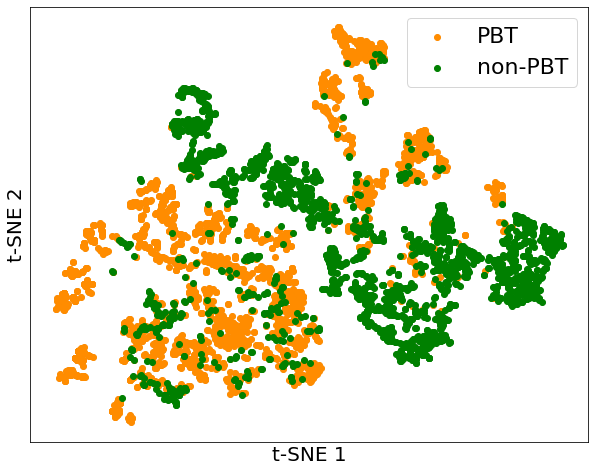

In [41]:
plt.figure(figsize=(10, 8))

# Scatter plots for the t-SNE data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='grey', alpha=0.2)
plt.scatter(X_tsne[np.where(np.array(startPBT_correct["PBT_label"]) == 1), 0], 
            X_tsne[np.where(np.array(startPBT_correct["PBT_label"]) == 1), 1], 
            c='darkorange', label='PBT')
plt.scatter(X_tsne[np.where(np.array(startPBT_correct["PBT_label"]) == 0), 0], 
            X_tsne[np.where(np.array(startPBT_correct["PBT_label"]) == 0), 1], 
            c='green', label='non-PBT')

# Labels for the axes
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Move the legend to the right
plt.legend(fontsize=22, loc='upper right')

#plt.savefig('images/tsne_A_Fig2.png', dpi=600, bbox_inches='tight')

plt.show()


Now We want to investigate **B) the overlap between the compiled dataset (PBT and non-PBT)  (gray) and Agrochemicals (yellow) datasets**, and **C) overlap between the compiled dataset (gray) and  DrugBank data (pink) in the defined chemical space.**

1. Concatenate features from the three datasets: PBT dataset, agrochemicals and DrugBank data

In [42]:
features_tot =pd.concat((features_PBT, features_agro, features_DrugBank))

2. Standardized features using MinMaxScaler

In [43]:
features_tot_scaled=pd.DataFrame(MinMaxScaler().fit_transform(features_tot), columns=features_tot.columns)

In [44]:
features_tot_scaled

,MolWt,HBA,HBD,NumRotafeaturescBonds,NumHalogens,NumHeteroatoms,FractionCSP3,RingCount,TPSA,Stereocenters,NumArR,NumAliR,logP
0,0.128921,0.008264,0.000000,0.134228,0.000000,0.020408,1.000000,0.000000,0.004857,0.000000,0.000000,0.000000,0.669434
1,0.022148,0.016529,0.000000,0.006711,0.019608,0.020408,0.250000,0.000000,0.013841,0.000000,0.000000,0.000000,0.488654
2,0.056930,0.000000,0.000000,0.000000,0.098039,0.034014,0.142857,0.028571,0.000000,0.000000,0.045455,0.000000,0.580910
3,0.042540,0.008264,0.000000,0.000000,0.039216,0.020408,0.000000,0.057143,0.006783,0.000000,0.090909,0.000000,0.546551
4,0.035858,0.008264,0.012195,0.000000,0.000000,0.020408,0.000000,0.057143,0.008310,0.000000,0.090909,0.000000,0.534913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17570,0.088413,0.074380,0.012195,0.040268,0.000000,0.061224,0.380952,0.114286,0.059078,0.000000,0.136364,0.033333,0.528369
17571,0.082765,0.074380,0.000000,0.026846,0.000000,0.061224,0.300000,0.142857,0.059683,0.000000,0.181818,0.033333,0.526465
17572,0.087552,0.049587,0.036585,0.046980,0.019608,0.047619,0.217391,0.114286,0.040769,0.037736,0.181818,0.000000,0.564383
17573,0.098411,0.066116,0.024390,0.033557,0.000000,0.054422,0.192308,0.142857,0.050194,0.018868,0.181818,0.033333,0.553932


3. Create t-SNE plot for Agrochemicals (Figure 2b)

In [45]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Fit and transform the dataset
X_tsne = tsne.fit_transform(features_tot_scaled)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


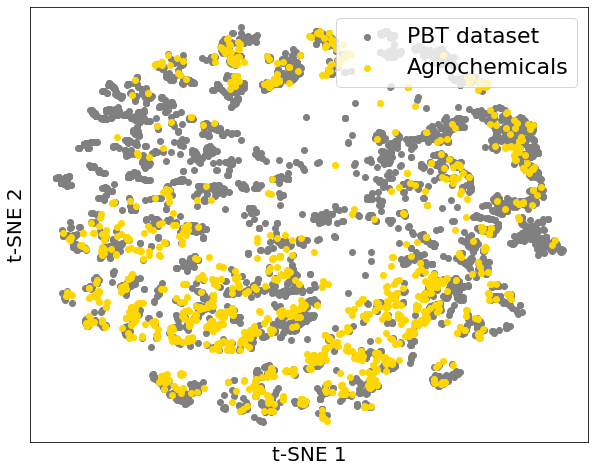

In [46]:
# Plot the t-SNE points
plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[:5128,0], X_tsne[:5128,1], label='PBT dataset', c = 'grey')
plt.scatter(X_tsne[5129:6405, 0], X_tsne[5129:6405, 1], label='Agrochemicals', c='gold')

plt.xlabel('t-SNE 1', fontsize = 20)
plt.ylabel('t-SNE 2', fontsize = 20)

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Move the legend to the right
plt.legend(fontsize=22, loc='upper right')

#plt.savefig('images/tsne_B_Fig2.png', dpi=600, bbox_inches='tight')
plt.show()

3. Create **t-SNE plot C DrugBank**

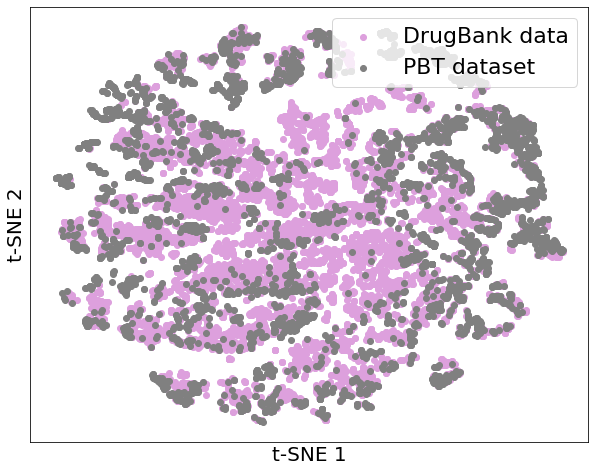

In [47]:
# Plot the t-SNE points
plt.figure(figsize=(10, 8))

plt.scatter(X_tsne[6405:, 0], X_tsne[6405:, 1], label='DrugBank data', c='plum')
plt.scatter(X_tsne[:5128,0], X_tsne[:5128,1], label='PBT dataset', c = 'grey')

plt.xlabel('t-SNE 1', fontsize = 20)
plt.ylabel('t-SNE 2', fontsize = 20)

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Move the legend to the right
plt.legend(fontsize=22, loc='upper right')
#plt.savefig('images/tsne_C_Fig2.png', dpi=600, bbox_inches='tight')
plt.show()

## Dataset partitioning prior to MPNN model training

In the following section we will consider three strategies for splitting the data into training and test sets: random splitting, clustering-based splitting, and cluster-centroid splitting. The first strategy involved randomly dividing the dataset with an 80:20 ratio (train: 4,104; test: 1,026). In the second and third approach the dataset will be divided into structurally homogeneous groups using the Butina clustering algorithm.

### Generating fingerprints

In [48]:
startPBT_correct

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [49]:
compounds = []
none_indices = []

for index, smiles in startPBT_correct[['SMILES']].itertuples():
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        none_indices.append(index)
    else:
        compounds.append(mol)

In [50]:
fps = []
for smiles in startPBT_correct['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        fps.append(fingerprints)
#fps

In [51]:
len(fps)

5130

### Tanimoto similarity and distance matrix

Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids. For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [52]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [53]:
#Calculate single similarity of two fingerprints
sim = DataStructs.TanimotoSimilarity(fps[0], fps[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.02, distance: 0.98


In [54]:
#Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fps)[0:5]

[0.9849624060150376,
 0.9805194805194806,
 0.9714285714285714,
 0.9817073170731707,
 0.9523809523809523]

### Clustering molecules
In this part, we cluster the molecules and look at the results.

Define a clustering function.

In [55]:
def cluster_fingerprints(fps, cutoff=0.4):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fps), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Cluster the molecules based on their fingerprint similarity.

In [56]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fps, cutoff=0.4)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  1650
# clusters with only 1 compound:  1066
# clusters with >5 compounds:  164
# clusters with >25 compounds:  24
# clusters with >100 compounds:  2


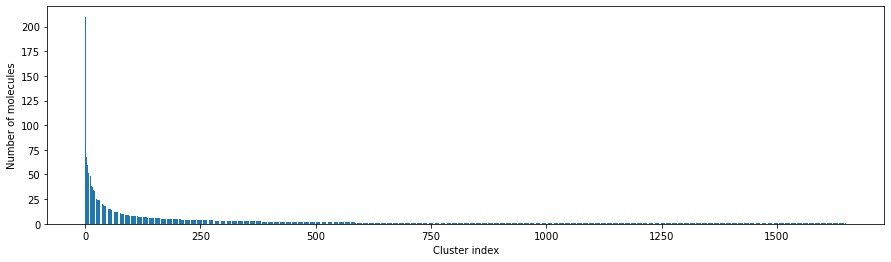

In [57]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

#### Visualizing the clusters¶
10 examples from largest cluster¶
Now, let’s have a closer look at the first 10 molecular structures of the first/largest clusters.

In [58]:
# Assuming 'clusters' is a list of lists, where each sublist is a cluster
singleton_clusters = [c for c in clusters if len(c) == 1]
non_singleton_clusters = [c for c in clusters if len(c) > 1]

# If you need to extract the cluster centers, you would need additional information
# about how the clusters were formed. Typically, the first or the most central
# compound could be considered the 'center'. This is a simplistic approach:
cluster_centers = [c[0] for c in non_singleton_clusters]  # Taking the first element as the center

print("total # clusters: ", len(clusters))
print("# singleton clusters: ", len(singleton_clusters))
print("# non-singleton clusters: ", len(non_singleton_clusters))

# If you need to do something with the singleton clusters or the cluster centers, you can now do so.

total # clusters:  1650
# singleton clusters:  1066
# non-singleton clusters:  584


In [59]:
len(cluster_centers)

584

In [60]:
# If 'molecules' is a list where the index corresponds to the molecule:
singleton_molecules = [compounds[c[0]] for c in singleton_clusters]
non_singleton_centres = [[compounds[i] for i in c] for c in non_singleton_clusters]

In [61]:
len(singleton_molecules)

1066

In [62]:
# Flatten the list of non-singleton clusters to get all molecule indices or identifiers in non-singleton clusters
non_singleton_molecule_ids = [id for cluster in non_singleton_clusters for id in cluster]

non_singleton_molecules = [compounds[id] for id in non_singleton_molecule_ids]

In [63]:
len(non_singleton_molecules)

4064

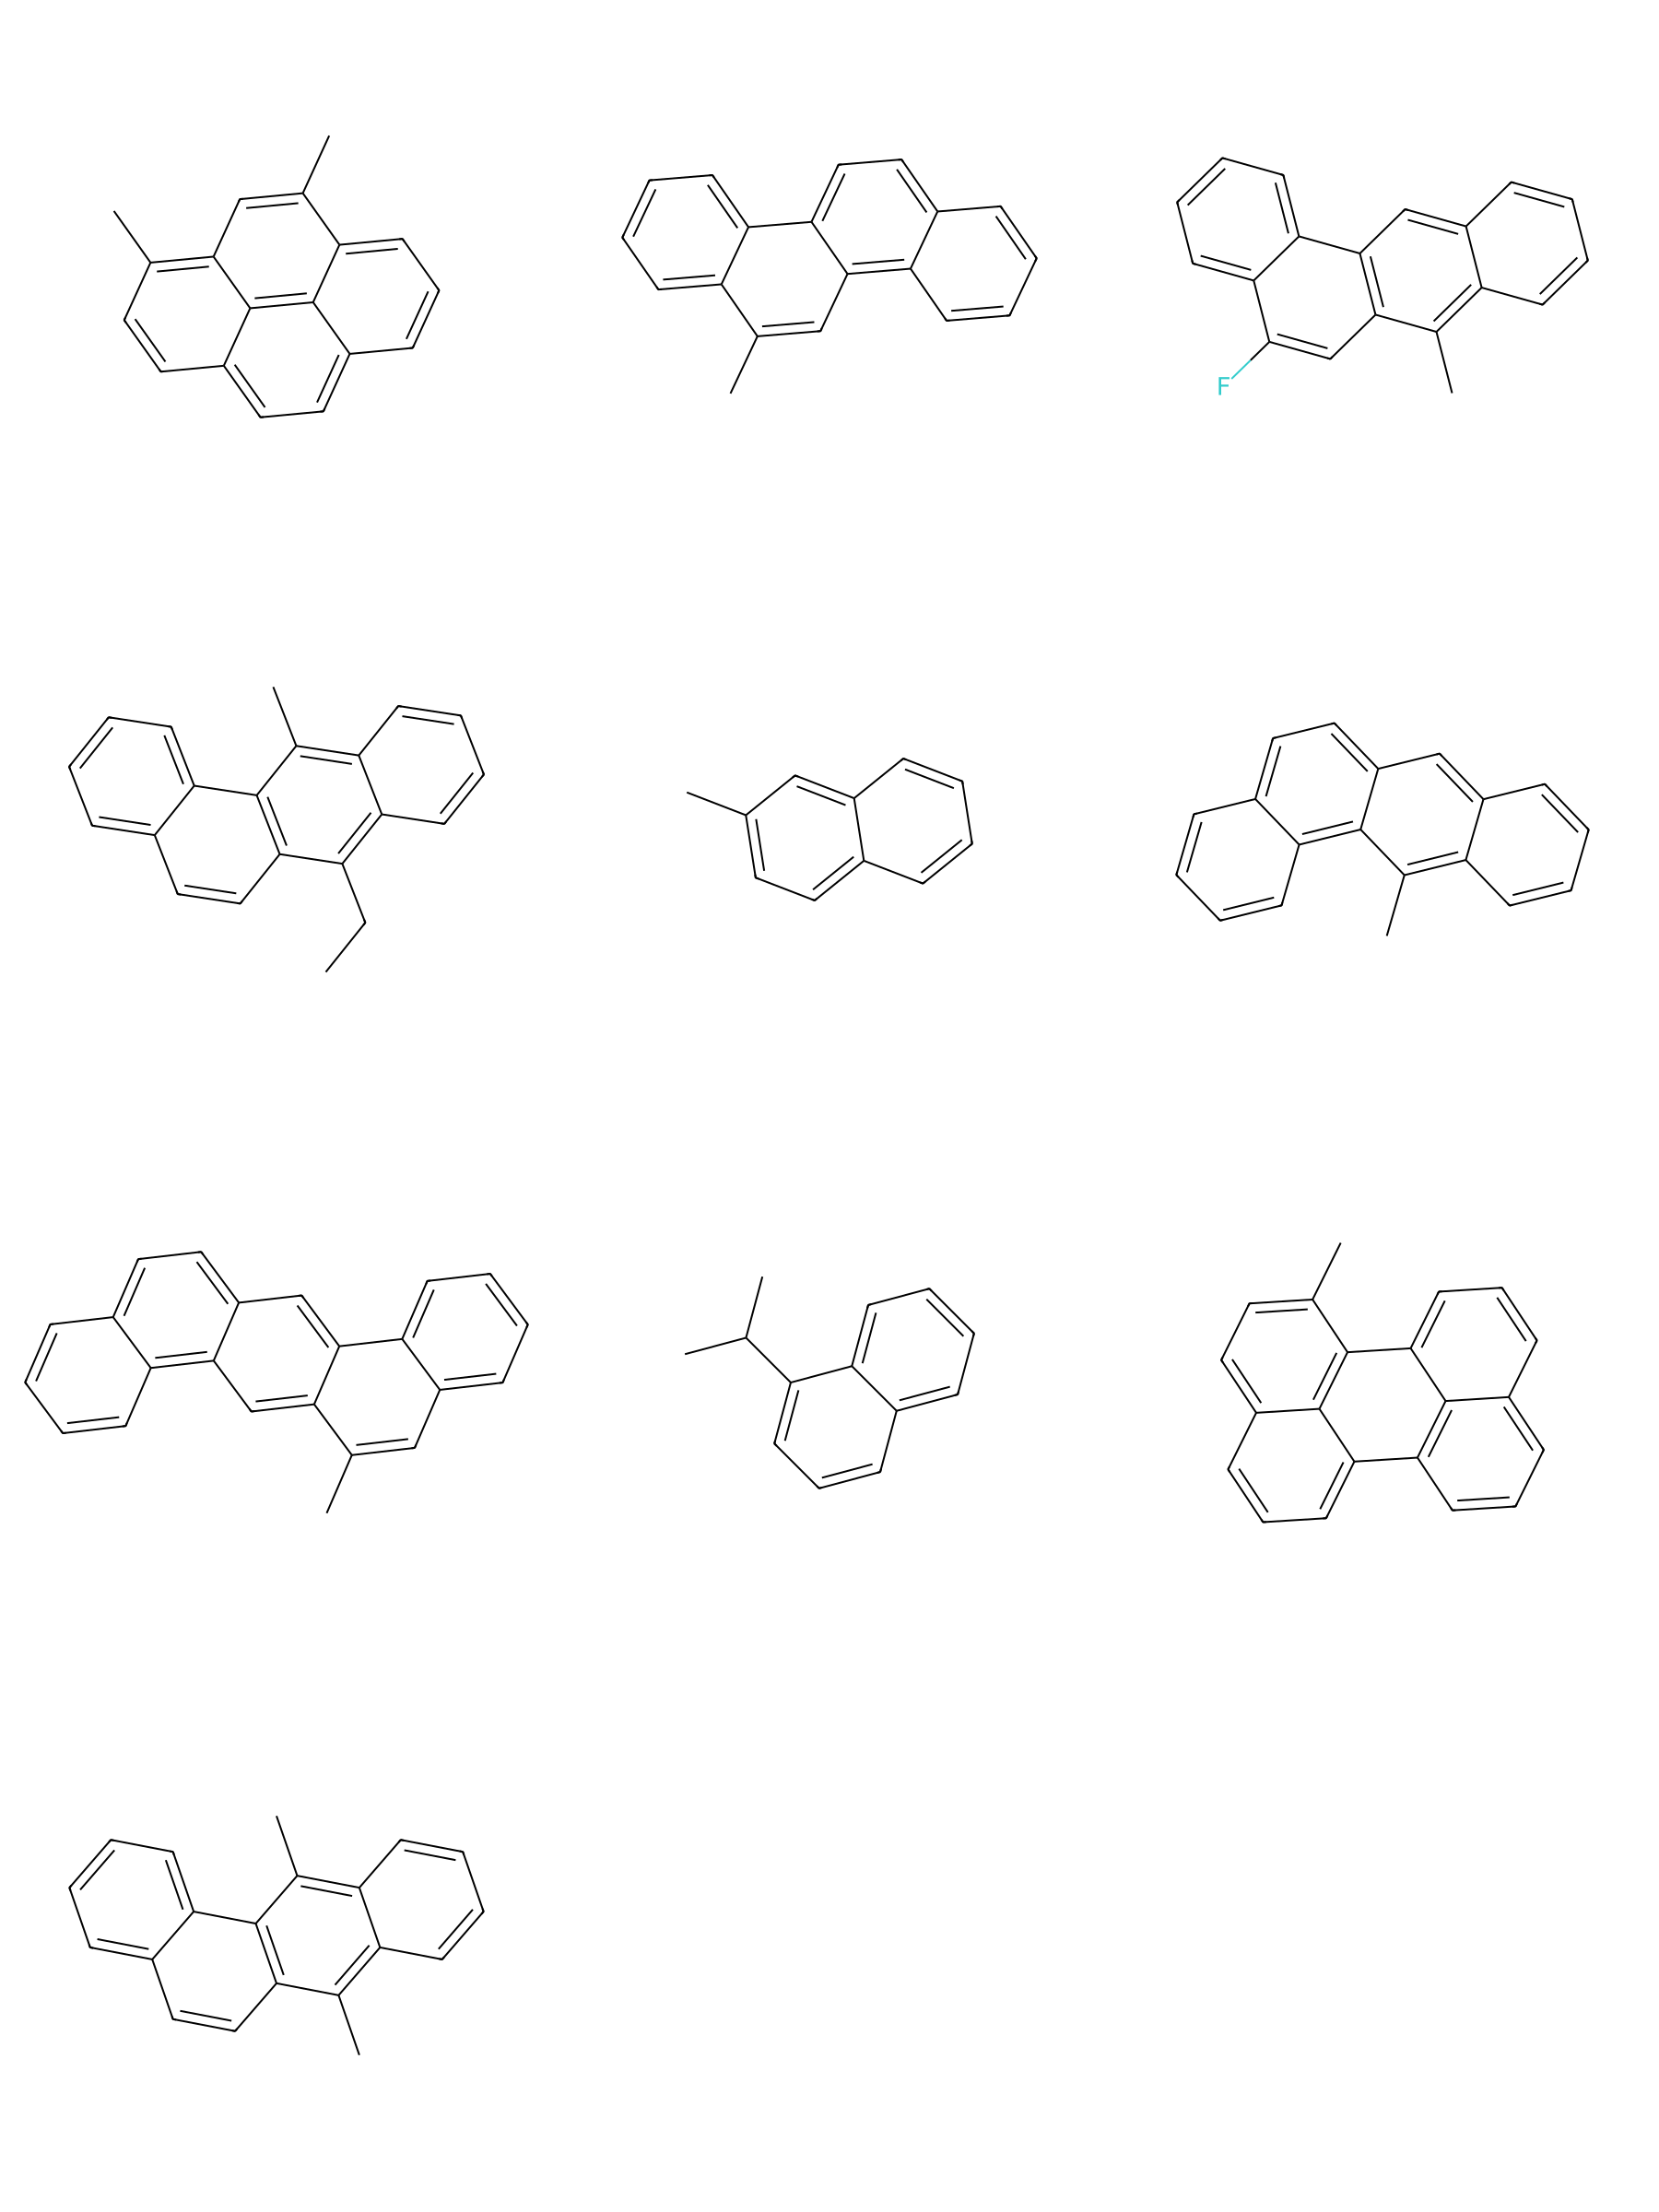

In [64]:
# Get the first 10 molecules from the largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[1][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

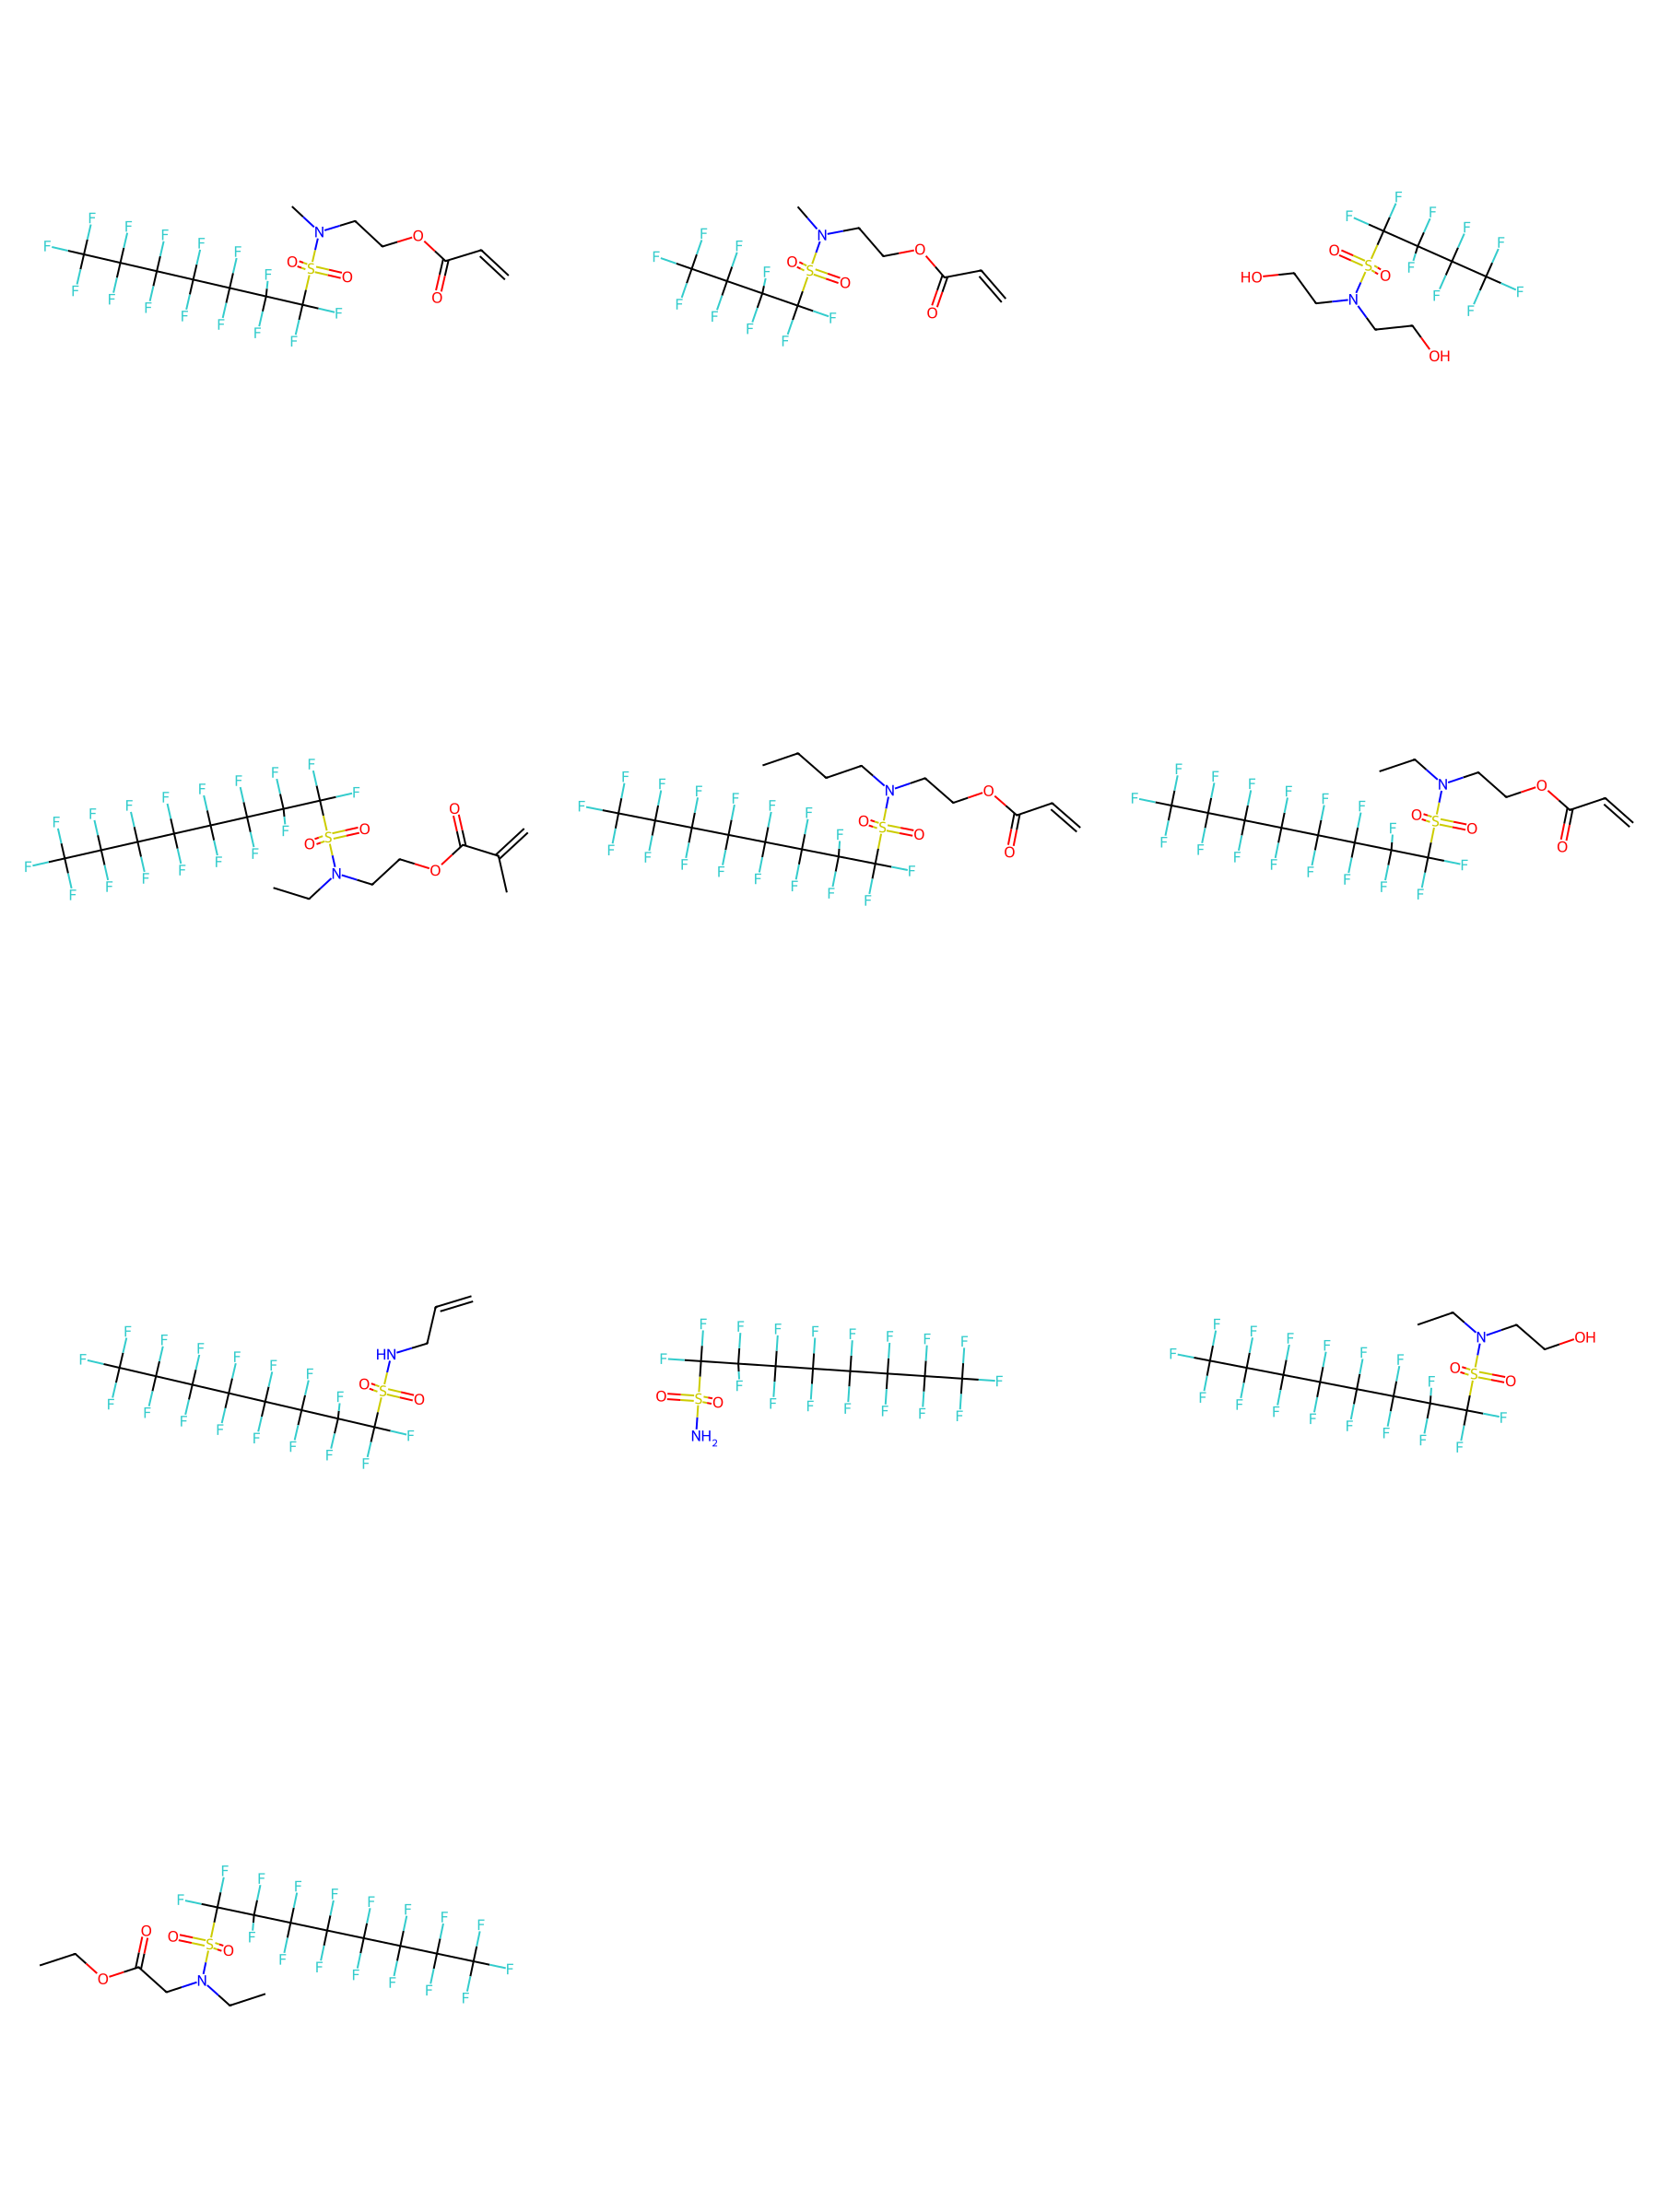

In [65]:
# Get the first 10 molecules from the second largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[2][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

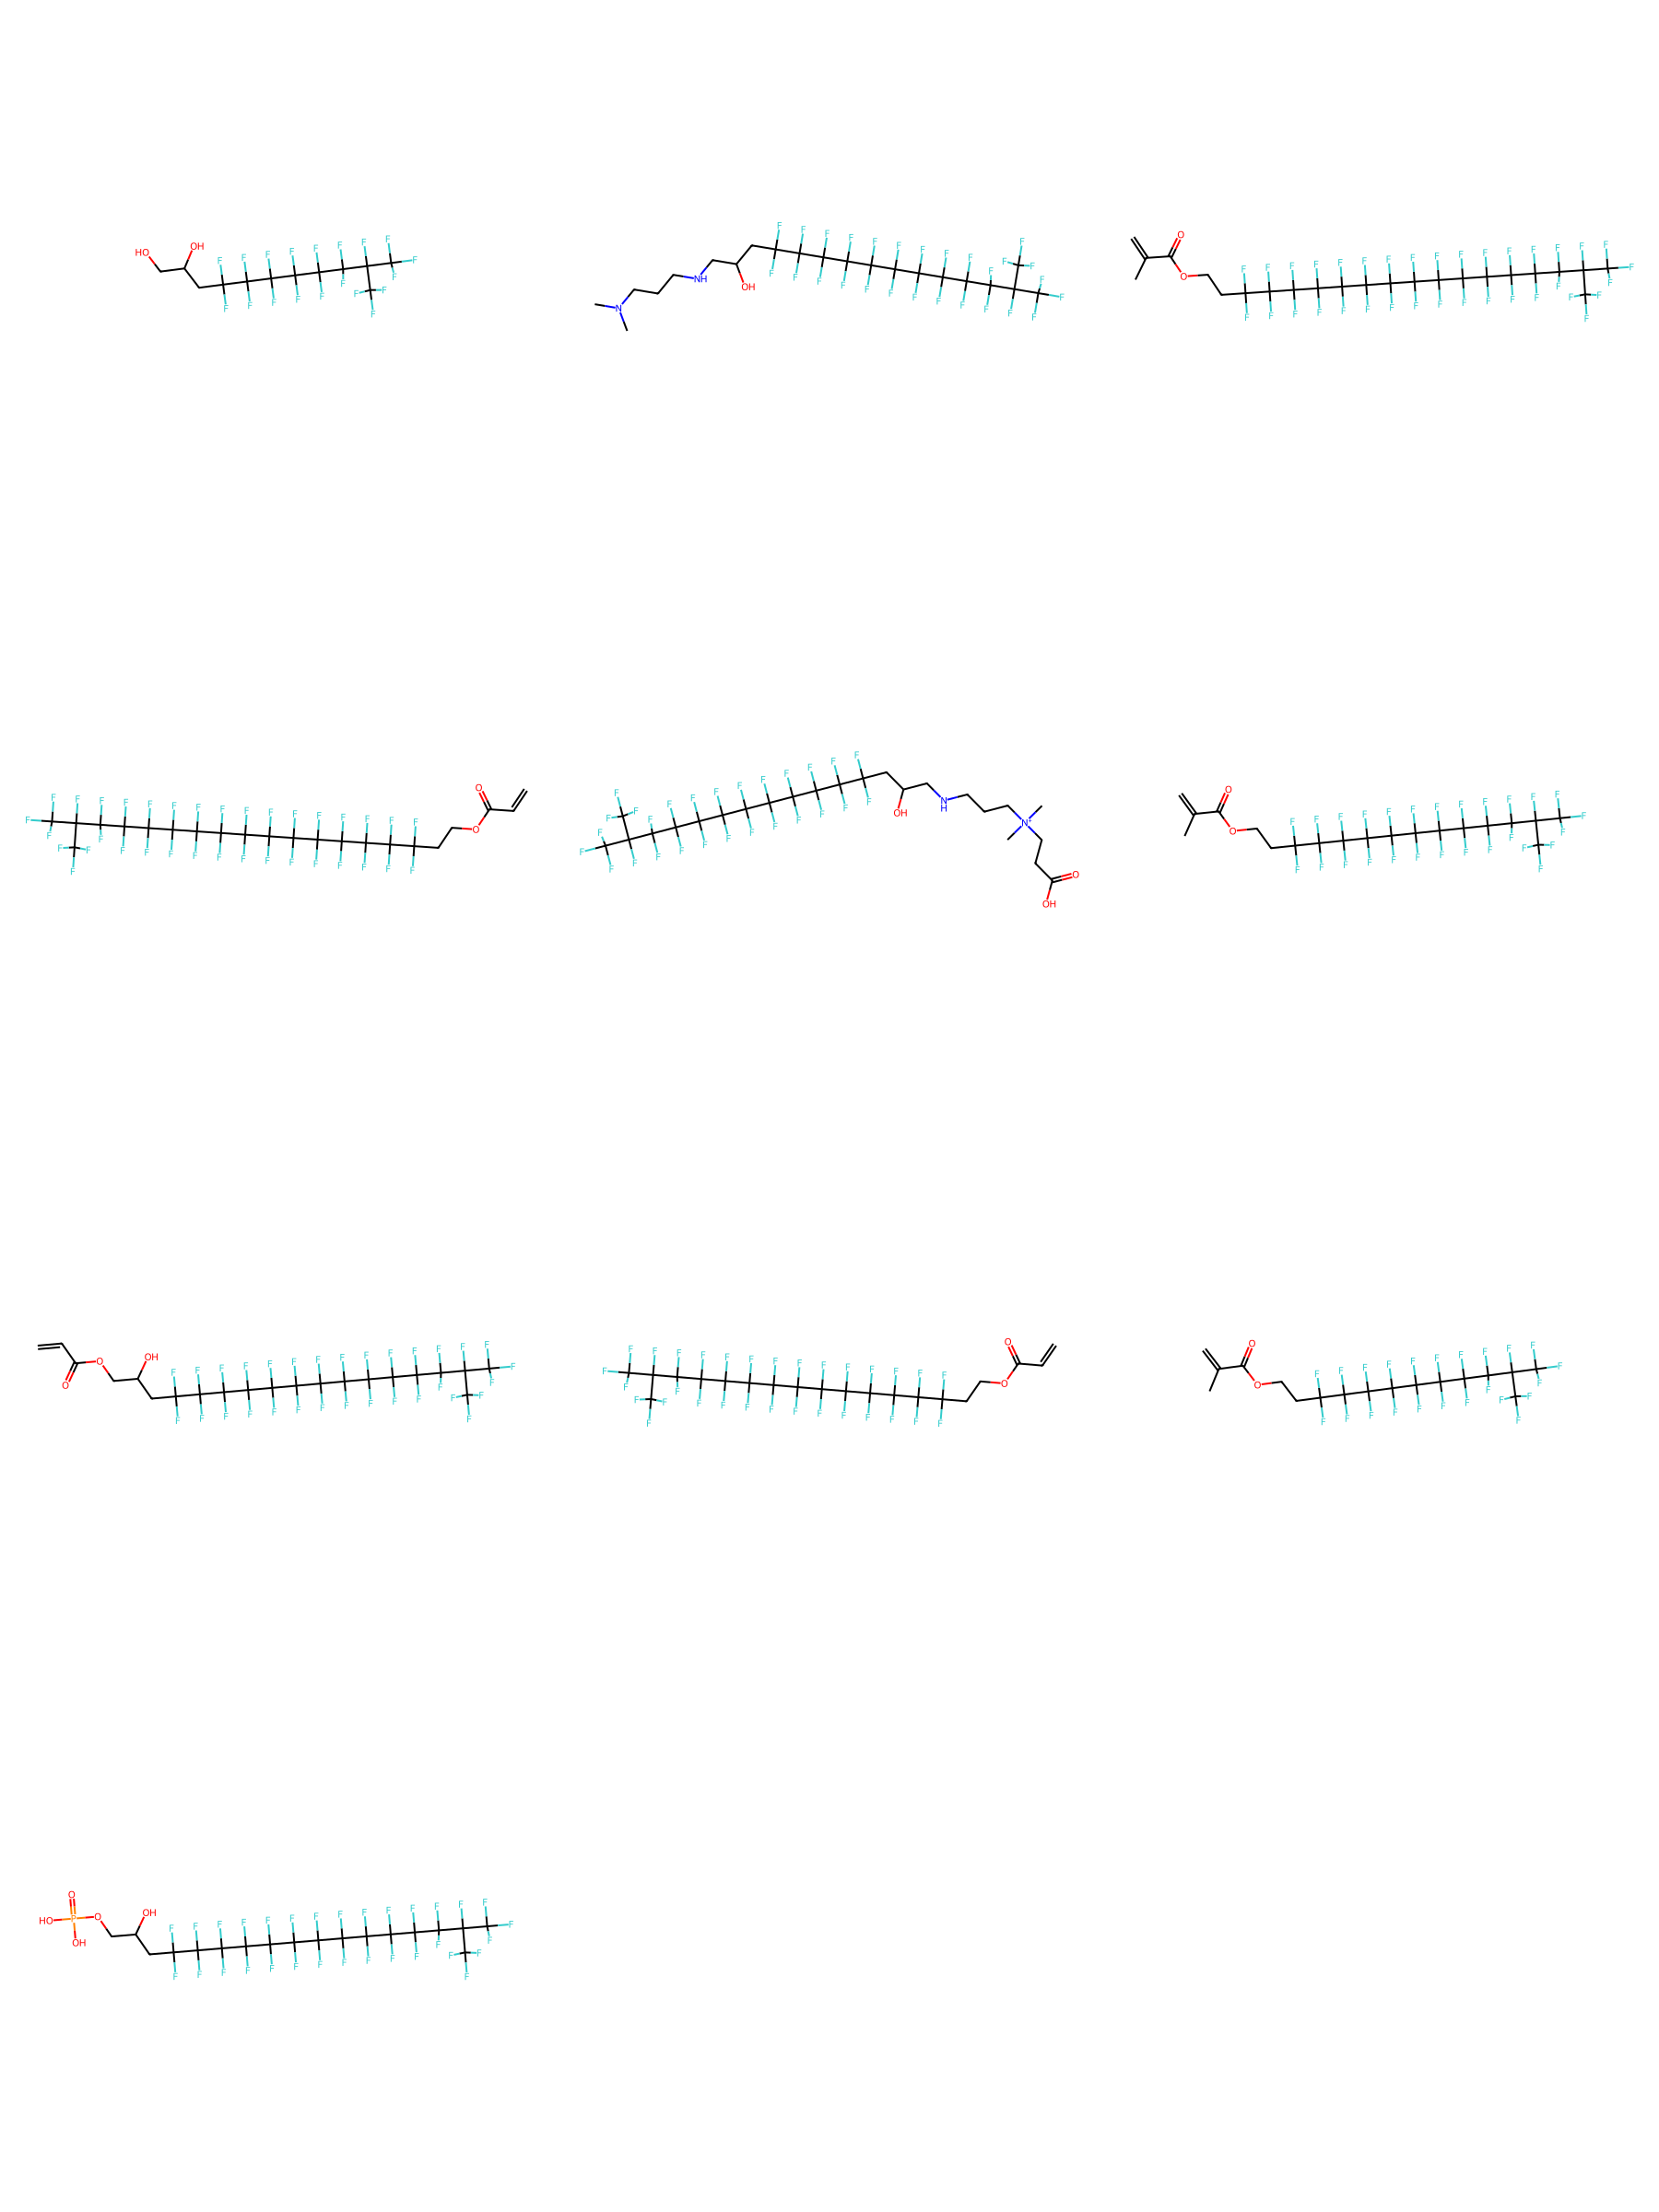

In [66]:
# Get the first 10 molecules from the third largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[3][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

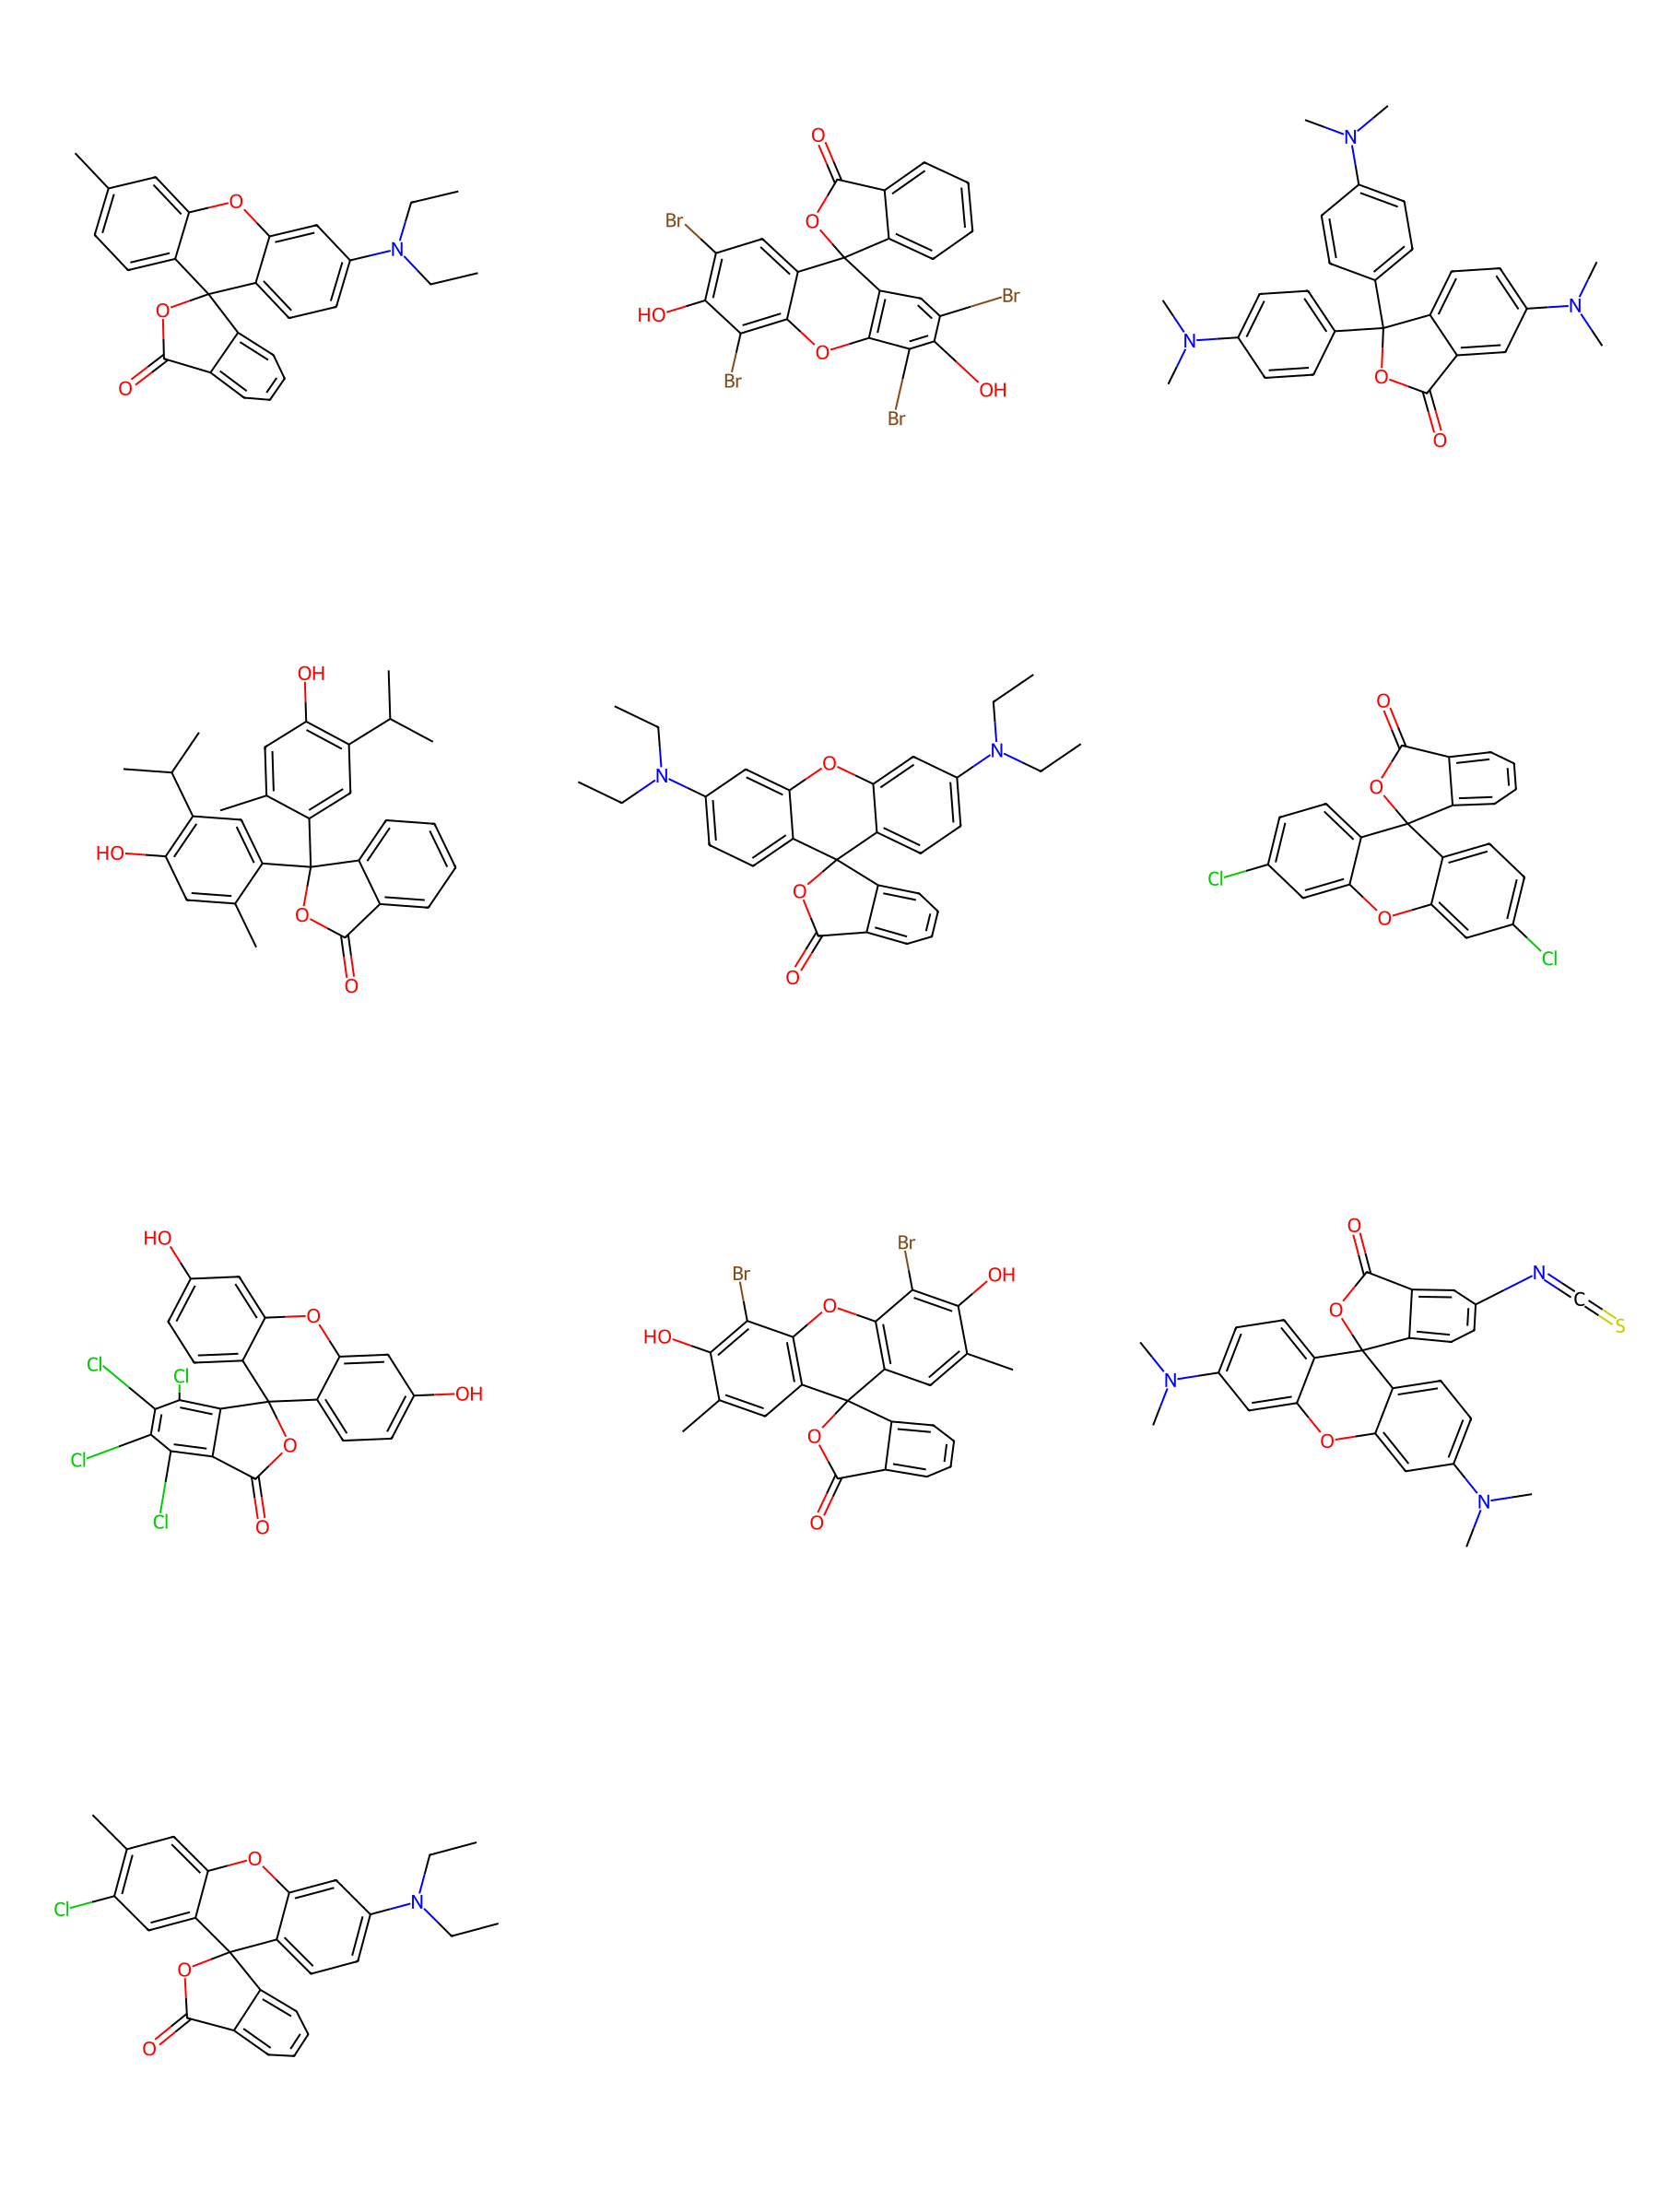

In [67]:
# Get the first 10 molecules from the fourth largest cluster
selected_mols = [compounds[i] for i in non_singleton_clusters[4][:10]]

# Draw molecules
Draw.MolsToGridImage(
    selected_mols,
    molsPerRow=3,
    subImgSize=(600,600)
)

#### Intra-cluster Tanimoto similarities fon non_singleton_molecules¶
We can also have a look at the intra-cluster Tanimoto similarities.

In [68]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [69]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in non_singleton_clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


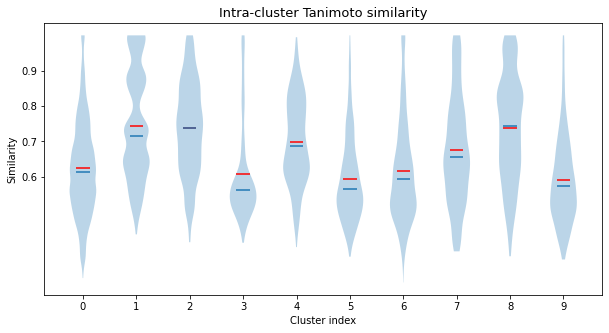

In [70]:
# Violin plot with intra-cluster similarity
fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

#### **Building new Training set for Clustering splitting**

In [71]:
# Convert mol objects to SMILES strings
training_smiles_list = [Chem.MolToSmiles(mol) for mol in non_singleton_molecules]
# Convert list to DataFrame
df = pd.DataFrame(training_smiles_list, columns=['SMILES'])
df

,SMILES
0,O=C1CCCCCO1
1,CCCCCCCCCCCCCCCCCC(=O)O
2,CCCCCCCCCC(=O)O
3,CCCCCCCCCCCCCCCCCCCCCC(=O)O
4,O=C(O)CCCCC(=O)O
...,...
4059,O=P(O)(O)O
4060,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...
4061,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...
4062,FC(F)CC(F)(F)F


In [72]:
training_dat = startPBT_correct[startPBT_correct['SMILES'].isin(df['SMILES'])]
training_dat

,SMILES,PBT_label
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
5,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
6,CC(O)C(=O)O,0
7,Cc1ccccc1Cl,0
...,...,...
5124,CN(C)CCCCCCN(C)C,0
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [73]:
# Count 1s and 0s in the second column
count_1s = training_dat['PBT_label'].value_counts().get(1, 0)
count_0s = training_dat['PBT_label'].value_counts().get(0, 0)

print(f'Number of 1s: {count_1s}')
print(f'Number of 0s: {count_0s}')

Number of 1s: 2271
Number of 0s: 1793


In [74]:
training_dat.to_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv', index = False)

#### **Building new test set for Clustering splitting**

In [75]:
# Convert mol objects to SMILES strings
test_smiles_list = [Chem.MolToSmiles(mol) for mol in singleton_molecules]
# Convert list to DataFrame
df = pd.DataFrame(test_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCCCC(CC)COC(=O)CS
1,CCOC(=O)CC(C(C)=O)C(=O)OCC
2,CCCCCCC(O)CC=CCCCCCCCC(=O)OC
3,CC(C)=CCN1CCC23CCCCC2C1Cc1ccc(OC(=O)c2cccnc2)cc13
4,CC(=O)OCCC(C)OC(C)=O
...,...
1061,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1
1062,O=S(=O)(O)C(F)(F)F
1063,S=c1[nH]c2ccccc2s1
1064,C=C(F)C(=O)OC


In [76]:
# Filter df_cross_PBT for only rows with common_elements
singletons = startPBT_correct[startPBT_correct['SMILES'].isin(df['SMILES'])]
singletons

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
4,S=c1[nH]c2ccccc2s1,0
10,O=S(=O)(O)C(F)(F)F,0
30,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
5109,NCCCN1CCN(CCCN)CC1,0
5110,CC(=O)NNC(C)=O,0
5111,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
5116,C=CC(=O)NCNC(=O)C=C,0


In [77]:
singletons.to_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv', index = False)

#### **Building second new Training set with only cluster centres for Cluster-centroids splitting**

In [78]:
cluster_centres_mol = [compounds[c[0]] for c in non_singleton_clusters]

In [79]:
len(cluster_centres_mol)

584

In [80]:
# Convert mol objects to SMILES strings
training_smiles_list = [Chem.MolToSmiles(mol) for mol in cluster_centres_mol]
# Convert list to DataFrame
df_train = pd.DataFrame(training_smiles_list, columns=['SMILES'])
df_train

,SMILES
0,O=C1CCCCCO1
1,Cc1cc2c(C)ccc3ccc4cccc1c4c32
2,C=CC(=O)OCCN(C)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C...
3,OCC(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...
4,CCN(CC)c1ccc2c(c1)Oc1cc(C)ccc1C21OC(=O)c2ccccc21
...,...
579,CCN(CC)c1ccc2cc(-c3nc4ccccc4[nH]3)c(=O)oc2c1
580,FC(F)Cl
581,O=[P+]([O-])[O-]
582,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...


In [81]:
cluster_centroids = startPBT_correct[startPBT_correct['SMILES'].isin(df_train['SMILES'])]
cluster_centroids

,SMILES,PBT_label
3,Clc1ccc2c(Cl)ccnc2c1,0
12,NC(=Nc1ccccc1)Nc1ccccc1,0
28,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
58,COC(=O)C(F)(F)F,0
64,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
5089,CC(C)C(NC(N)=O)NC(N)=O,0
5094,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
5101,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
5102,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [82]:
cluster_centroids.to_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv', index= False)

### Split Data
#### Random Splitting

In [84]:
startPBT_correct

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [85]:
# Split the data into training and test sets (80:20)
train_random_df, test_random_df = train_test_split(startPBT_correct, test_size=0.2, random_state=42)

# Save the split datasets
train_random_df.to_csv('Splitting_strategy_datasets/new_train2_random_data.csv', index=False)
test_random_df.to_csv('Splitting_strategy_datasets/new_test2_random_data.csv', index=False)

In [86]:
df_randomsplit_train = pd.read_csv('Splitting_strategy_datasets/new_train2_random_data.csv')
df_randomsplit_train

,SMILES,PBT_label
0,CCCN(CCC)c1ccc(-c2nc(-c3ccc(N(C)C)cc3)c(-c3ccc...,1
1,C=CC(=O)OCCCCO,0
2,CC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C3CCC2(C)OC(C)...,1
3,CCCCOCC1CO1,0
4,CCCCCCCCCCCCCCCCOC(=O)C=CC(=O)O,0
...,...,...
4099,CCCCCCCCCCCCCCCCCC[Si](C)(C)Cl,0
4100,O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
4101,O=C(O)C(F)(C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(...,1
4102,c1ccc(C2=NCCN2)cc1,0


In [87]:
random_train_fps = []
for smiles in df_randomsplit_train['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        random_train_fps.append(fingerprints)
#random_train_fps

In [88]:
len(random_train_fps)

4104

In [89]:
df_randomsplit_test = pd.read_csv('Splitting_strategy_datasets/new_test2_random_data.csv')
df_randomsplit_test

,SMILES,PBT_label
0,CC(CC(C)C)=NCCNCCN=C(C)CC(C)C,0
1,CC(C)c1cccc2cc3c(ccc4ccccc43)cc12,1
2,CCCCCCCCC=CCCCCCCCC(=O)NCC(C)OC(=O)CC(C(=O)O)S...,0
3,CC(=O)OC1CCC2(C)C(CCC3C2CC(=O)C2(C)C3CC3OC4(CC...,1
4,Oc1c(Br)cc(Cc2cc(Br)c(O)c(Br)c2)cc1Br,1
...,...,...
1021,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,1
1022,Cc1ccc(Nc2nc(C(Cl)(Cl)Cl)nc(C(Cl)(Cl)Cl)n2)cc1,1
1023,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)Br,1
1024,CCO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,1


In [90]:
random_test_fps = []
for smiles in df_randomsplit_test['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        random_test_fps.append(fingerprints)
#random_test_fps

In [91]:
len(random_test_fps)

1026

In [92]:
all_sim = []  
max_sim = []  

for train_fp in random_train_fps:
    for test_fp in random_test_fps:
        similarity = DataStructs.TanimotoSimilarity(train_fp, test_fp)
        max_sim.append(similarity)  
    all_sim.append(max(max_sim)) 
    max_sim = [] 

In [93]:
len(all_sim)

4104

#### Clustering splitting

Here, the test set only encompassed singletons, i.e. molecules that were the only member of their clusters; all other, non-singleton molecules were included in the training set (train: 4064 chemicals, test: 1065). 

In [94]:
Clustering_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Clustering_training_PBT.csv')
Clustering_trainmol

,SMILES,PBT_label
0,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
1,Clc1ccc2c(Cl)ccnc2c1,0
2,Brc1c(Br)c(Br)c2c(c1Br)Oc1ccccc1O2,1
3,CC(O)C(=O)O,0
4,Cc1ccccc1Cl,0
...,...,...
4059,CN(C)CCCCCCN(C)C,0
4060,CN(C)CCCN(C)C,0
4061,C[N+](C)(C)C1CCCCC1,0
4062,c1ccc(N(CC2CO2)CC2CO2)cc1,0


In [95]:
cluster_train_fps = []
for smiles in Clustering_trainmol['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        cluster_train_fps.append(fingerprints)
#cluster_train_fps

In [96]:
len(cluster_train_fps)

4064

In [97]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


In [98]:
singleton_test_fps = []
for smiles in singleton_testmol['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        singleton_test_fps.append(fingerprints)
#singleton_test_fps

In [99]:
all_sim_cs = []  # List to hold the maximum similarity for each fingerprint in non_sing_fps
max_sim_cs = []  # Temporary list to hold similarities for the current non_sing_fp against all sing_fps

for cluster_fp in cluster_train_fps:
    for sing_fp in singleton_test_fps:
        similarity = DataStructs.TanimotoSimilarity(cluster_fp, sing_fp)
        max_sim_cs.append(similarity)  # Add the similarity to the temporary list
    if max_sim_cs:  # Check if max_sim_cs is not empty
        all_sim_cs.append(max(max_sim_cs))  # Find the maximum similarity for the current non_sing_fp and add it to all_sim_cs
    else:
        all_sim_cs.append(0)  # Append a default value if max_sim_cs is empty (e.g., 0 or None)
    max_sim_cs = []  # Reset the temporary list for the next non_sing_fp

# Now, all_sim_cs contains the maximum similarity each fingerprint in non_sing_fps has with any fingerprint in sing_fps


In [100]:
len(all_sim_cs)

4064

#### Cluster-centroids splitting

Last, to test our approach, we only considered **cluster centroids**, i.e. a single representative molecule from each cluster, for the training set and singletons in the test set (train: 586 centroids, test: 1062).

In [101]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,SMILES,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


In [102]:
centres_train_fps = []
for smiles in Centres_trainmol['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        centres_train_fps.append(fingerprints)
#centres_train_fps

In [103]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


In [104]:
singleton_test_fps = []
for smiles in singleton_testmol['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
        fingerprints = rdkit_gen.GetFingerprint(mol)
        singleton_test_fps.append(fingerprints)
#singleton_test_fps

In [105]:
all_sim_cc = []  # List to hold the maximum similarity for each fingerprint in non_sing_fps
max_sim_cc = []  # Temporary list to hold similarities for the current non_sing_fp against all sing_fps

for centres_fp in centres_train_fps:
    for sing_fp in singleton_test_fps:
        similarity = DataStructs.TanimotoSimilarity(centres_fp, sing_fp)
        max_sim_cc.append(similarity)  # Add the similarity to the temporary list
    if max_sim_cc:  # Check if max_sim_cs is not empty
        all_sim_cc.append(max(max_sim_cc))  # Find the maximum similarity for the current non_sing_fp and add it to all_sim_cs
    else:
        all_sim_cc.append(0)  # Append a default value if max_sim_cs is empty (e.g., 0 or None)
    max_sim_cc = []  # Reset the temporary list for the next non_sing_fp


In [106]:
len(all_sim_cc)

584

### Figure 3: Boxplot of Tanimoto similarities between training and test sets for different data splitting strategies 
Boxplot displaying the distribution of maximum Tanimoto similarities between training and test sets for different data splitting strategies: random (orange box), clustering (yellow box) and cluster-centroids (green box) splitting. 

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.flo

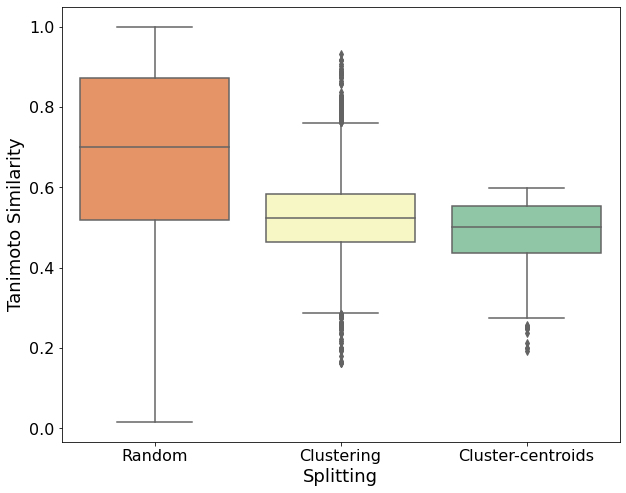

In [107]:
data = {
    'Tanimoto Similarity': all_sim + all_sim_cs + all_sim_cc,
    'Splitting': ['Random'] * len(all_sim) + ['Clustering'] * len(all_sim_cs) + ['Cluster-centroids'] * len(all_sim_cc)
}

df = pd.DataFrame(data)

# Create the box plot with specified colors
plt.figure(figsize=(10, 8))
sns.boxplot(x='Splitting', y='Tanimoto Similarity', data=df, palette='Spectral')
sns.set(style="darkgrid")
plt.xticks(rotation=0, fontsize = 18)  # Rotate labels to avoid overlap
plt.xlabel('Splitting', fontsize=18)
plt.ylabel('Tanimoto Similarity', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
bbox_props = dict(boxstyle="round,pad=0.3", ec="black", fc="white", alpha=0.7)

#plt.savefig('images/new_boxplot.png', dpi=300, bbox_inches='tight' )
plt.show()

#### **Median Similarities** 

In [108]:
np.median(all_sim)

0.7010420023633044

In [109]:
np.median(all_sim_cs)

0.5248276334413954

In [110]:
np.median(all_sim_cc)

0.5

#### **% of maxumum Tanimoto similarities above a cut-off value of 0.6**

Considering a Tanimoto similarity value of 0.6 as indicative of structural contiguity, we also added the percentage of maximum similarities that were above the cut-off value for each splitting method.

#### **Random Splitting**

In [111]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff = [sim for sim in all_sim if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff = len(maxsim_above_cutoff)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff = (num_maxsim_above_cutoff / len(all_sim)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff:.2f}%")

Number of similarities above 0.6: 2666
Percentage of similarities above 0.6: 64.96%


#### **Clustering splitting**

In [112]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff_cs = [sim for sim in all_sim_cs if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff_cs = len(maxsim_above_cutoff_cs)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff_cs = (num_maxsim_above_cutoff_cs / len(all_sim_cs)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff_cs}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff_cs:.2f}%")

Number of similarities above 0.6: 725
Percentage of similarities above 0.6: 17.84%


#### **Cluster-centroids splitting**

In [113]:
# Cut-off value
cut_off_value = 0.6

# Filter similarities above the cut-off value
maxsim_above_cutoff_cc = [sim for sim in all_sim_cc if sim > cut_off_value]

# Count the number of similarities above the cut-off value
num_maxsim_above_cutoff_cc = len(maxsim_above_cutoff_cc)

# Calculate the percentage of similarities above the cut-off value
percentage__maxsim_above_cutoff_cc = (num_maxsim_above_cutoff_cc / len(all_sim_cc)) * 100

print(f"Number of similarities above {cut_off_value}: {num_maxsim_above_cutoff_cc}")
print(f"Percentage of similarities above {cut_off_value}: {percentage__maxsim_above_cutoff_cc:.2f}%")

Number of similarities above 0.6: 0
Percentage of similarities above 0.6: 0.00%


In the following section we will compare the proposed model (***the model trained on cluster centroids***) with the GP-QSPR prediction to the test set of singletons and we will show results as confusion matrices.

## Figure 4: Confusion Matrix comparing QSAR to Deep Learning 
Comparison of GP-QSPR and DL-based model prediction on a test set of 1065 dissimilar singletons. The confusion matrices for the GP-QSPR model (A) and DL-based model (B) predictions illustrate the performances by extracting Accuracy  and Recall of each model, respectively. 

### DL-based model vs GP-QSPR model on the test set of dissimilar singletons

In [114]:
singleton_testmol = pd.read_csv('Splitting_strategy_datasets/new_singletons_test_PBT.csv')
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


We first use the proposed model to predict the test set of dissimilar singletons

To run the model predicting using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run the **Prediction Command**
```bash
chemprop_predict --test_path Splitting_strategy_datasets/new_singletons_test_PBT.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ \
                 --preds_path 0fold_outputs/CC_results_nok/test_final_CC_predictions.csv
```

3. after completing the **Prediction command** in bash returns to this notebook

In [115]:
test_final_pred = pd.read_csv('0fold_outputs/CC_results_nok/test_final_CC_predictions.csv')

In [116]:
test_final_pred['PBT_bin_pred'] = (test_final_pred['PBT_label'] > 0.51).astype(int)
test_final_pred.columns = [['SMILES', 'PBT_pred', 'PBT_bin_pred']]
test_final_pred

,SMILES,PBT_pred,PBT_bin_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063,0
1,C=C(F)C(=O)OC,0.000273,0
2,S=c1[nH]c2ccccc2s1,0.005313,0
3,O=S(=O)(O)C(F)(F)F,0.000527,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,0.762580,1
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0.003541,0
1061,CC(=O)NNC(C)=O,0.000040,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0.382319,0
1063,C=CC(=O)NCNC(=O)C=C,0.000039,0


In [117]:
#test_final_pred.to_csv('singletons1065_DLprediction.csv', index = False)

In [118]:
singletons_DLpred = pd.read_csv('singletons1065_DLprediction.csv')
singletons_DLpred

,SMILES,PBT_pred,PBT_bin_pred
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063,0
1,C=C(F)C(=O)OC,0.000273,0
2,S=c1[nH]c2ccccc2s1,0.005313,0
3,O=S(=O)(O)C(F)(F)F,0.000527,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,0.762580,1
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0.003541,0
1061,CC(=O)NNC(C)=O,0.000040,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0.382319,0
1063,C=CC(=O)NCNC(=O)C=C,0.000039,0


### Confusion Matrix for DL-based model prediction

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


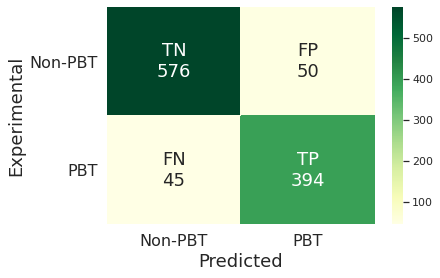

In [119]:
y_true = singleton_testmol['PBT_label']
y_pred = singletons_DLpred['PBT_bin_pred']


cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', annot_kws={"size": 16},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'}, ax=ax)

# Define custom labels for the axes
tick_labels = ['Non-PBT', 'PBT']
# Setting the tick labels on both axes
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Rotate the tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Annotate each cell with the respective quadrant label
quadrant_labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        text = ax.texts[i*2+j]
        text.set_text(f'{quadrant_labels[i][j]}\n{text.get_text()}')
        text.set_fontsize(18)  # Increase font size of quadrant labels

# Setting the labels and title
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('Experimental', fontsize=18)
ax.set_xticklabels(tick_labels, fontsize=16)
ax.set_yticklabels(tick_labels, fontsize=16)
#plt.savefig('images/Fig4_DLpred.png', dpi=600, bbox_inches='tight')

plt.show()


In [120]:
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  

print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')

Accuracy: 0.91
Sensitivity (Recall): 0.90


Here we developed a Python script to calculate the **PBT function according to the original GP-QSPR equation developed by Papa and Gramatica using experimental data for P, B and T**

### Confusion Matrix for GP-QSPR

#### **Defining GP-QSPR PBT function with RDkit**

In [121]:
# from RDKit source defining parameters
def GetPrincipleQuantumNumber(atNum):
  """ Get principal quantum number for atom number """
  if atNum <= 2:
    return 1
  if atNum <= 10:
    return 2
  if atNum <= 18:
    return 3
  if atNum <= 36:
    return 4
  if atNum <= 54:
    return 5
  if atNum <= 86:
    return 6
  return 7

def EStateAll(mol, force=True):
  """ returns a tuple of EState indices for the molecule
    Reference: Hall, Mohney and Kier. JCICS _31_ 76-81 (1991)
  """
  if not force and hasattr(mol, '_eStateIndices'):
    return mol._eStateIndices

  tbl = Chem.GetPeriodicTable()
  nAtoms = mol.GetNumAtoms()
  Is = np.zeros(nAtoms, dtype=np.float64)
  for i in range(nAtoms):
    at = mol.GetAtomWithIdx(i)
    d = at.GetDegree()
    if d > 0:
      atNum = at.GetAtomicNum()
      dv = tbl.GetNOuterElecs(atNum) - at.GetTotalNumHs()
      N = GetPrincipleQuantumNumber(atNum)
      Is[i] = (4. / (N * N) * dv + 1) / d
  dists = Chem.GetDistanceMatrix(mol, useBO=0, useAtomWts=0) + 1
  
  accum = np.zeros(nAtoms, dtype=np.float64)
  for i in range(nAtoms):
    for j in range(i + 1, nAtoms):
      p = dists[i, j]
      if p < 1e6:
        tmp = (Is[i] - Is[j]) / (p * p)
        accum[i] += tmp
        accum[j] -= tmp
  
  res = accum + Is
  mol._eStateIndices = res
  return res, Is, accum

def MaxISDiff(mol):
    EStates, IEStates, ISDiff = EStateAll(mol)
    return max(ISDiff)

def CountMultipleBonds(mol):
    
    nBM=0
    for bond in mol.GetBonds():
        if rdchem.Bond.GetBondTypeAsDouble(bond) > 1:
            nBM=nBM+1

    return nBM

In [122]:
# defining PBT function
def CalcPBT(mol): 
     
    xN = Fragments.fr_halogen(mol)
    
    HBD = rdMolDescriptors.CalcNumLipinskiHBD(mol)
    
    nBM = CountMultipleBonds(mol)
    
    MAXDP = MaxISDiff(mol)
    
    PBT=-1.5 + 0.64*xN + 0.22*nBM + -0.39*HBD + -0.062*MAXDP 

    return xN,HBD,nBM,MAXDP,PBT

In [123]:
singleton_testmol

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,S=c1[nH]c2ccccc2s1,0
3,O=S(=O)(O)C(F)(F)F,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1
...,...,...
1060,NCCCN1CCN(CCCN)CC1,0
1061,CC(=O)NNC(C)=O,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0
1063,C=CC(=O)NCNC(=O)C=C,0


In [124]:
singleton_testmol['mol'] = singleton_testmol['SMILES'].apply(Chem.MolFromSmiles)
singleton_testmol

,SMILES,PBT_label,mol
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea870>
1,C=C(F)C(=O)OC,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018ead50>
2,S=c1[nH]c2ccccc2s1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018eaed0>
3,O=S(=O)(O)C(F)(F)F,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea5d0>
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea750>
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1330>
1061,CC(=O)NNC(C)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1390>
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a13f0>
1063,C=CC(=O)NCNC(=O)C=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1450>


In [125]:
QSPR_PBT_test = [CalcPBT(molz) for molz in singleton_testmol['mol']]

In [126]:
singleton_testmol[['xN', 'HBD', 'nBM', 'MAXDP', 'PBT_QSPR']] = singleton_testmol['mol'].apply(CalcPBT).apply(pd.Series)

In [127]:
singleton_testmol

,SMILES,PBT_label,mol,xN,HBD,nBM,MAXDP,PBT_QSPR
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea870>,0.0,0.0,0.0,4.358333,-1.770217
1,C=C(F)C(=O)OC,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018ead50>,1.0,0.0,2.0,3.426343,-0.632433
2,S=c1[nH]c2ccccc2s1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018eaed0>,0.0,1.0,11.0,1.309259,0.448826
3,O=S(=O)(O)C(F)(F)F,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea5d0>,3.0,1.0,2.0,2.724537,0.301079
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1,<rdkit.Chem.rdchem.Mol object at 0x7f42018ea750>,2.0,1.0,12.0,5.195194,1.707898
...,...,...,...,...,...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1330>,0.0,4.0,0.0,1.487733,-3.152239
1061,CC(=O)NNC(C)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1390>,0.0,2.0,2.0,3.022361,-2.027386
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a13f0>,0.0,0.0,14.0,1.803607,1.468176
1063,C=CC(=O)NCNC(=O)C=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f42018a1450>,0.0,2.0,4.0,3.475328,-1.615470


In [128]:
singletons_QSPR = singleton_testmol[['SMILES', 'PBT_label', 'PBT_QSPR']].copy()
singletons_QSPR

,SMILES,PBT_label,PBT_QSPR
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,-1.770217
1,C=C(F)C(=O)OC,0,-0.632433
2,S=c1[nH]c2ccccc2s1,0,0.448826
3,O=S(=O)(O)C(F)(F)F,0,0.301079
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1,1.707898
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0,-3.152239
1061,CC(=O)NNC(C)=O,0,-2.027386
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0,1.468176
1063,C=CC(=O)NCNC(=O)C=C,0,-1.615470


#### Binary classification for GP-QSPR prediction

In [129]:
threshold = 1.5
singletons_QSPR['PBT_QSPR']= np.where(singletons_QSPR['PBT_QSPR'] > threshold, 1, 0)

In [130]:
singletons_QSPR

,SMILES,PBT_label,PBT_QSPR
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,0
1,C=C(F)C(=O)OC,0,0
2,S=c1[nH]c2ccccc2s1,0,0
3,O=S(=O)(O)C(F)(F)F,0,0
4,COC1(c2ccc(F)cc2)CCC(NCCCOc2ccc(F)cc2)CC1,1,1
...,...,...,...
1060,NCCCN1CCN(CCCN)CC1,0,0
1061,CC(=O)NNC(C)=O,0,0
1062,CN(C(=S)SSC(=S)N(C)c1ccccc1)c1ccccc1,0,0
1063,C=CC(=O)NCNC(=O)C=C,0,0


#### Confusion Matrix for GP-QSPR prediction

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


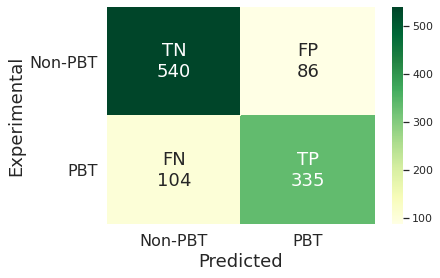

In [131]:
y_true = singletons_QSPR['PBT_label']
y_pred = singletons_QSPR['PBT_QSPR']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', annot_kws={"size": 16},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'}, ax=ax)

# Define custom labels for the axes
tick_labels = ['Non-PBT', 'PBT']
# Setting the tick labels on both axes
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Rotate the tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


# Annotate each cell with the respective quadrant label
quadrant_labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        text = ax.texts[i*2+j]
        text.set_text(f'{quadrant_labels[i][j]}\n{text.get_text()}')
        text.set_fontsize(18)


# Setting the labels and title
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('Experimental', fontsize=18)
ax.set_xticklabels(tick_labels, fontsize=16)
ax.set_yticklabels(tick_labels, fontsize=16)

#plt.savefig('images/FIg4_QSARpred.png', dpi=600, bbox_inches='tight')

plt.show()



In [132]:
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')

Accuracy: 0.82
Sensitivity (Recall): 0.76


## Interpretability Analysis 

In the following section, we will identify **specific chemical substructures** that are linked to PBT (Persistence, Bioaccumulation, and Toxicity) classification using the built-in `interpret` function in Chemprop. We will start with the dataset of cluster centroids from our compiled dataset to interpret our proposed model. By identifying key molecular substructures, we aim to pinpoint which parts of each molecule are primarily responsible for Chemprop’s predictions.

In [133]:
Centres_trainmol = pd.read_csv('Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv')
Centres_trainmol

,SMILES,PBT_label
0,Clc1ccc2c(Cl)ccnc2c1,0
1,NC(=Nc1ccccc1)Nc1ccccc1,0
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,1
3,COC(=O)C(F)(F)F,0
4,O=C1c2ccccc2C(=O)c2ccccc21,0
...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0


To execute the interpretation run using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run **Chemprop Interpret** Command


```bash
chemprop_interpret \
    --data_path Splitting_strategy_datasets/new_Cluster_centroids_training_PBT.csv \
    --features_generator rdkit_2d_normalized \
    --no_features_scaling \
    --min_atoms 4 \
    --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ \
    --property_id 1 \
    >> outputs_pred_interpr/Oct_interpret_CS_PBT2.log &
```

3. after completing the **Interpret command** in bash returns to this notebook

In [134]:
## Elapsed time = 4:49:09

### Substructure Interpretation Analysis

In the following section, we use the output ftom the '**interpret**' run (***Oct_interpret_CS_PBT2.log***) to extract substructures responsible for **PBT** (Persistent, Bioaccumulative, and Toxic) behaviour, . 

**Key findings**:
- **198** substructures were identified as responsible for PBT behavior in at least one compound
- Among these, **18** substructures appeared multiple times
- After applying RDKit's **FindMCS()** function:
  - The 18 recurring substructures were consolidated into **13** PBT-related substructures
      - **3** PBT-associated Maximum Common Substructures (MCSs) were identified

**Analysis of Substructure Distribution**:
- Counted matched molecules containing these substructures for:
  - PBT and non-PBT molecules in the experimental dataset
  - PBT and non-PBT molecules in the prediction dataset
- Calculated **Enrichment Factor (EF)** for both:
  - Experimental dataset
  - Prediction dataset

In [135]:
interpret_cc = pd.read_csv('outputs_pred_interpr/Oct_interpret_CS_PBT2.log')
# Remove square brackets from SMILES strings
interpret_cc['smiles'] = interpret_cc['smiles'].str.strip("['']")
interpret_cc

,smiles,PBT_label,rationale,rationale_score
0,Clc1ccc2c(Cl)ccnc2c1,0.223,NaN,NaN
1,NC(=Nc1ccccc1)Nc1ccccc1,0.002,NaN,NaN
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504
3,COC(=O)C(F)(F)F,0.006,NaN,NaN
4,O=C1c2ccccc2C(=O)c2ccccc21,0.023,NaN,NaN
...,...,...,...,...
579,CC(C)C(NC(N)=O)NC(N)=O,0.000,NaN,NaN
580,C[Si](NC1CCCCC1)(NC1CCCCC1)NC1CCCCC1,0.079,NaN,NaN
581,O=C1CCCCCN1C(=O)Nc1ccc(Cc2ccc(NC(=O)N3CCCCCC3=...,0.674,NaN,NaN
582,CC1(C)CC(N(C=O)CCCCCCN(C=O)C2CC(C)(C)NC(C)(C)C...,0.576,NaN,NaN


In [136]:
# Drop nan values
filtered_df = interpret_cc.dropna(subset=['rationale', 'rationale_score'])
# Replace ':1' with '' in the 'substructure' column
filtered_df['Substructure'] = filtered_df['rationale'].str.replace(':1', '', regex=False)
filtered_df

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,smiles,PBT_label,rationale,rationale_score,Substructure
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504,Brc1c[cH]cc(Br)[cH]1
10,COc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.993,Clc1c(Cl)[cH:1][cH:1][cH:1]c1Cl,0.831,Clc1c(Cl)[cH][cH][cH]c1Cl
11,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,1.000,FC(F)([CH3:1])[CH:1](F)F,0.659,FC(F)([CH3])[CH](F)F
13,CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)...,0.973,CC12CC[CH2:1]CC1=CCC1C2CC[CH:1]2C1C[CH2:1][CH2...,0.750,CC12CC[CH2]CC1=CCC1C2CC[CH]2C1C[CH2][CH2]2
14,COc1ccc(C(c2ccc(OC)cc2)C(Cl)(Cl)Cl)cc1,0.743,ClC(Cl)(Cl)C(c1cc[cH:1]cc1)c1cc[cH:1]cc1,0.566,ClC(Cl)(Cl)C(c1cc[cH]cc1)c1cc[cH]cc1
...,...,...,...,...,...
328,O=C(O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,1.000,FC(F)(F)[CH:1](F)F,0.795,FC(F)(F)[CH](F)F
361,CCCCC(CC)COP1Oc2c(cc(C(C)(C)C)cc2C(C)(C)C)Cc2c...,0.997,c1c2c(c([CH3:1])c[cH:1]1)O[PH:1]Oc1c(c[cH:1]cc...,0.567,c1c2c(c([CH3])c[cH]1)O[PH]Oc1c(c[cH]cc1[CH3])C2
373,C=CC(=O)Oc1c(C(C)c2cc(C(C)(C)CC)cc(C(C)(C)CC)c...,0.983,c1c([CH3:1])cc([CH2:1]c2cc([CH3:1])cc([CH3:1])...,0.606,c1c([CH3])cc([CH2]c2cc([CH3])cc([CH3])[cH]2)[c...
408,CC(=O)Oc1c(C)c(C)c2c(c1C)CCC(C)(CCCC(C)CCCC(C)...,0.949,Cc1c2c([cH:1][cH:1]c1C)CCC(C)([CH3:1])O2,0.569,Cc1c2c([cH][cH]c1C)CCC(C)([CH3])O2


In [137]:
### canonicalize smiles strings
filtered_df['mol'] = filtered_df.apply(lambda x: Chem.MolFromSmiles(x['Substructure']), axis=1)
filtered_df['canonical_smi'] = filtered_df.apply(lambda x: Chem.MolToSmiles(x['mol']), axis=1)
filtered_df

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,smiles,PBT_label,rationale,rationale_score,Substructure,mol,canonical_smi
2,O=C1OC(c2cc(Br)c(O)c(Br)c2)(c2cc(Br)c(O)c(Br)c...,0.993,Brc1c[cH:1]cc(Br)[cH:1]1,0.504,Brc1c[cH]cc(Br)[cH]1,<rdkit.Chem.rdchem.Mol object at 0x7f4201570870>,Brc1cccc(Br)c1
10,COc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.993,Clc1c(Cl)[cH:1][cH:1][cH:1]c1Cl,0.831,Clc1c(Cl)[cH][cH][cH]c1Cl,<rdkit.Chem.rdchem.Mol object at 0x7f4201570810>,Clc1cccc(Cl)c1Cl
11,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,1.000,FC(F)([CH3:1])[CH:1](F)F,0.659,FC(F)([CH3])[CH](F)F,<rdkit.Chem.rdchem.Mol object at 0x7f42015703f0>,CC(F)(F)C(F)F
13,CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)...,0.973,CC12CC[CH2:1]CC1=CCC1C2CC[CH:1]2C1C[CH2:1][CH2...,0.750,CC12CC[CH2]CC1=CCC1C2CC[CH]2C1C[CH2][CH2]2,<rdkit.Chem.rdchem.Mol object at 0x7f42015700f0>,CC12CCCCC1=CCC1C3CCCC3CCC12
14,COc1ccc(C(c2ccc(OC)cc2)C(Cl)(Cl)Cl)cc1,0.743,ClC(Cl)(Cl)C(c1cc[cH:1]cc1)c1cc[cH:1]cc1,0.566,ClC(Cl)(Cl)C(c1cc[cH]cc1)c1cc[cH]cc1,<rdkit.Chem.rdchem.Mol object at 0x7f4201570210>,ClC(Cl)(Cl)C(c1ccccc1)c1ccccc1
...,...,...,...,...,...,...,...
328,O=C(O)C=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,1.000,FC(F)(F)[CH:1](F)F,0.795,FC(F)(F)[CH](F)F,<rdkit.Chem.rdchem.Mol object at 0x7f4201790450>,FC(F)C(F)(F)F
361,CCCCC(CC)COP1Oc2c(cc(C(C)(C)C)cc2C(C)(C)C)Cc2c...,0.997,c1c2c(c([CH3:1])c[cH:1]1)O[PH:1]Oc1c(c[cH:1]cc...,0.567,c1c2c(c([CH3])c[cH]1)O[PH]Oc1c(c[cH]cc1[CH3])C2,<rdkit.Chem.rdchem.Mol object at 0x7f42017904b0>,Cc1cccc2c1OPOc1c(C)cccc1C2
373,C=CC(=O)Oc1c(C(C)c2cc(C(C)(C)CC)cc(C(C)(C)CC)c...,0.983,c1c([CH3:1])cc([CH2:1]c2cc([CH3:1])cc([CH3:1])...,0.606,c1c([CH3])cc([CH2]c2cc([CH3])cc([CH3])[cH]2)[c...,<rdkit.Chem.rdchem.Mol object at 0x7f4201790510>,Cc1cc(C)cc(Cc2cc(C)cc(C)c2)c1
408,CC(=O)Oc1c(C)c(C)c2c(c1C)CCC(C)(CCCC(C)CCCC(C)...,0.949,Cc1c2c([cH:1][cH:1]c1C)CCC(C)([CH3:1])O2,0.569,Cc1c2c([cH][cH]c1C)CCC(C)([CH3])O2,<rdkit.Chem.rdchem.Mol object at 0x7f4201790570>,Cc1ccc2c(c1C)OC(C)(C)CC2


In [138]:
PBT_substructures = filtered_df[['canonical_smi', 'PBT_label', 'rationale_score']]
PBT_substructures

,canonical_smi,PBT_label,rationale_score
2,Brc1cccc(Br)c1,0.993,0.504
10,Clc1cccc(Cl)c1Cl,0.993,0.831
11,CC(F)(F)C(F)F,1.000,0.659
13,CC12CCCCC1=CCC1C3CCCC3CCC12,0.973,0.750
14,ClC(Cl)(Cl)C(c1ccccc1)c1ccccc1,0.743,0.566
...,...,...,...
328,FC(F)C(F)(F)F,1.000,0.795
361,Cc1cccc2c1OPOc1c(C)cccc1C2,0.997,0.567
373,Cc1cc(C)cc(Cc2cc(C)cc(C)c2)c1,0.983,0.606
408,Cc1ccc2c(c1C)OC(C)(C)CC2,0.949,0.569


In [139]:
## collect substructures recurring more than once
counts = dict(PBT_substructures['canonical_smi'].value_counts())
vals = {k:v for k,v in counts.items() if v>=2}
vals

{'Brc1cccc(Br)c1': 10,
 'CC(F)(F)C(F)F': 10,
 'Clc1cccc(Cl)c1Cl': 9,
 'FC(F)C(F)(F)F': 8,
 'Brc1ccccc1Br': 6,
 'CC12CCCC1C1CCCCC1CC2': 4,
 'CC12CCCCC1=CCC1C3CCCC3CCC12': 3,
 'CSc1nc(C)nc(C(Cl)(Cl)Cl)n1': 3,
 'Clc1ccc(Cl)c(Cl)c1': 3,
 'c1cc2ccc3cccc4ccc(c1)c2c34': 2,
 'c1ccc2cc3c(ccc4ccccc43)cc2c1': 2,
 'c1ccc2c(c1)Cc1ccccc1S2': 2,
 'ClC(Cl)(Cl)c1ncnc(C(Cl)(Cl)Cl)n1': 2,
 'ClC(Cl)C(Cl)Cl': 2,
 'Clc1cc(Cl)cc(Cl)c1': 2,
 'Clc1ccc(Cl)c(Br)c1': 2,
 'Cc1c(Cl)cccc1Cl': 2,
 'Ic1cccc(I)c1I': 2}

In [140]:
len(vals)

18

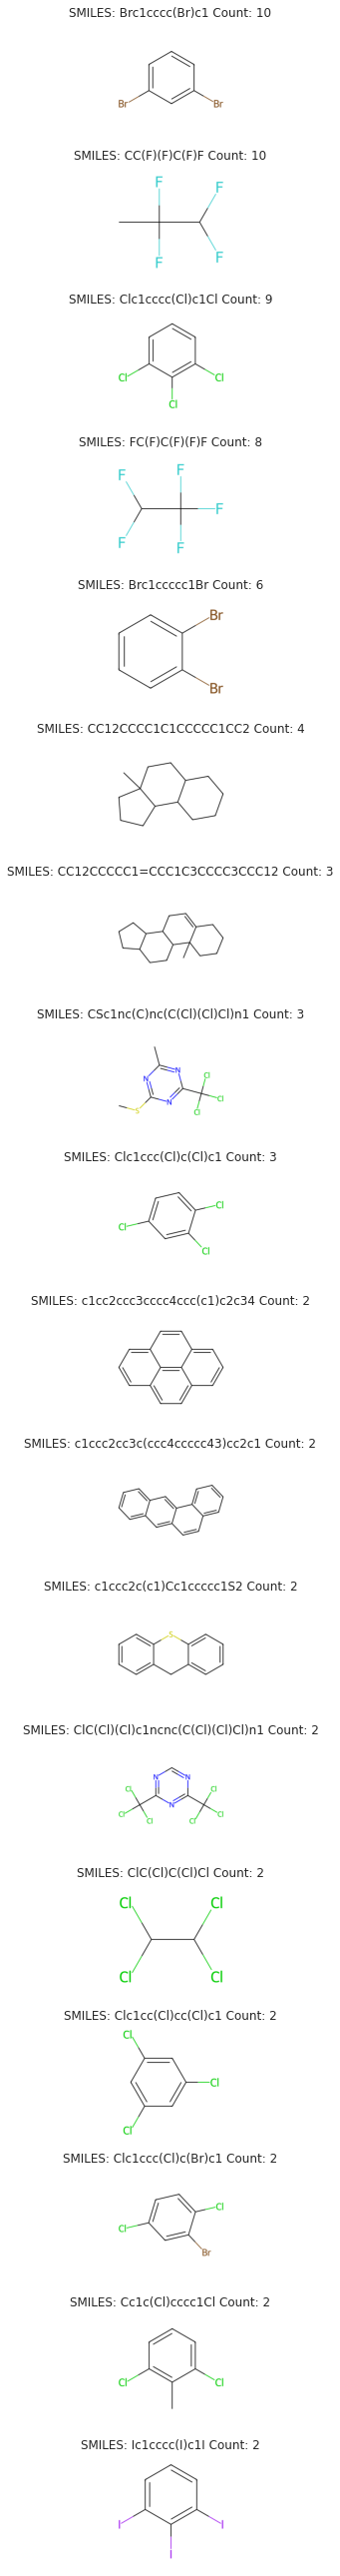

In [141]:
# Create a list of molecule objects from SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in vals.keys()]

# Setting up the plot
fig, axes = plt.subplots(nrows=len(mols), figsize=(10, len(mols) * 2))

# If there is only one molecule, we need to ensure axes is iterable
if len(mols) == 1:
    axes = [axes]

# Draw each molecule with its SMILE and count
for ax, mol, (smiles, count) in zip(axes, mols, vals.items()):
    img = Draw.MolToImage(mol, size=(300, 300))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'SMILES: {smiles} Count: {count}')

plt.tight_layout()
plt.show()

In [142]:
# Create lists for DataFrame Substructures construction
smiles_list = list(vals.keys())
mol_objects = [Chem.MolFromSmiles(sm) for sm in smiles_list]
counts_list = list(vals.values())

# Create the DataFrame
sub = pd.DataFrame({
    'smiles_substructures': smiles_list,
    'mol': mol_objects,
    'Count': counts_list
})

sub

,smiles_substructures,mol,Count
0,Brc1cccc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7f420195a150>,10
1,CC(F)(F)C(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f420155d0f0>,10
2,Clc1cccc(Cl)c1Cl,<rdkit.Chem.rdchem.Mol object at 0x7f42301a1f30>,9
3,FC(F)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f4201944d50>,8
4,Brc1ccccc1Br,<rdkit.Chem.rdchem.Mol object at 0x7f42019572d0>,6
5,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7f4201957270>,4
6,CC12CCCCC1=CCC1C3CCCC3CCC12,<rdkit.Chem.rdchem.Mol object at 0x7f4201957930>,3
7,CSc1nc(C)nc(C(Cl)(Cl)Cl)n1,<rdkit.Chem.rdchem.Mol object at 0x7f4201957e70>,3
8,Clc1ccc(Cl)c(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x7f4201957030>,3
9,c1cc2ccc3cccc4ccc(c1)c2c34,<rdkit.Chem.rdchem.Mol object at 0x7f4201957d50>,2


### Find Maximum Common Substructures

In [143]:
### Mols containing an aromatic ring and chlorine atoms
Clmols = [sub['mol'][2],
          sub['mol'][8], 
          sub['mol'][14], 
          sub['mol'][16]]

MCS.FindMCS(Clmols)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  import sys


MCSResult(numAtoms=8, numBonds=8, smarts='[Cl]-[#6]:1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[Cl]', completed=1)

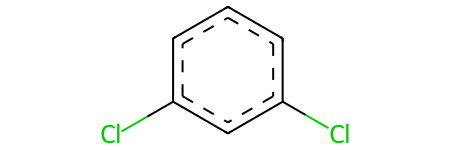

In [144]:
Clar1 = Chem.MolFromSmarts('[Cl]-[#6]:1:[#6]:[#6]:[#6]:[#6](:[#6]:1)-[Cl]')
Clar1

In [145]:
### Mols containing Fluorine atoms
Fmols = [sub['mol'][1], 
        sub['mol'][3]]
MCS.FindMCS(Fmols)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  after removing the cwd from sys.path.


MCSResult(numAtoms=6, numBonds=5, smarts='[#6](-[#6](-[F])-[F])(-[F])-[F]', completed=1)

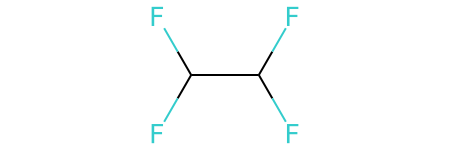

In [146]:
Fsub = Chem.MolFromSmarts('[#6](-[#6](-[F])-[F])(-[F])-[F]')
Fsub

In [147]:
### Mols containing Nitrogens and Chlorine atoms
Fmols = [sub['mol'][7], 
        sub['mol'][12]]
MCS.FindMCS(Fmols)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  after removing the cwd from sys.path.


MCSResult(numAtoms=11, numBonds=11, smarts='[#6]:1:[#7]:[#6](:[#7]:[#6](:[#7]:1)-[#6](-[Cl])(-[Cl])-[Cl])-[#6]', completed=1)

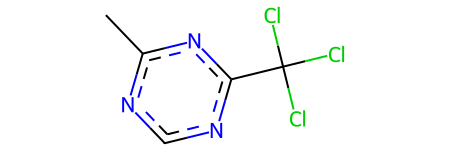

In [148]:
NClsub = Chem.MolFromSmarts('[#6]:1:[#7]:[#6](:[#7]:[#6](:[#7]:1)-[#6](-[Cl])(-[Cl])-[Cl])-[#6]')
NClsub

In [149]:
CSs = [sub['mol'][0], Fsub, Clar1, sub['mol'][4], sub['mol'][5], sub['mol'][6], sub['mol'][9], sub['mol'][10], sub['mol'][11], sub['mol'][13], sub['mol'][15], sub['mol'][17],  NClsub]
CSs

In [150]:
len(CSs)

13

In [151]:
smiles_list = [Chem.MolToSmiles(mol) for mol in CSs]

df13_sub = pd.DataFrame(smiles_list, columns=['SMILES'])
df13_sub

,SMILES
0,Brc1cccc(Br)c1
1,FC(F)C(F)F
2,ClC1:C:C:C:C(Cl):C:1
3,Brc1ccccc1Br
4,CC12CCCC1C1CCCCC1CC2
5,CC12CCCCC1=CCC1C3CCCC3CCC12
6,c1cc2ccc3cccc4ccc(c1)c2c34
7,c1ccc2cc3c(ccc4ccccc43)cc2c1
8,c1ccc2c(c1)Cc1ccccc1S2
9,ClC(Cl)C(Cl)Cl


In [152]:
#df13_sub.to_csv('outputs_pred_interpr/13substructures_smi.csv', index= False)

For each subsstructure identified we will count the matching molecules among PBT and non-PBT compounds together with an **enrichment factor (EF)**. EF values above 1 will indicate that the substructure is more often displayed by PBT compounds.

In [153]:
startPBT_correct

,SMILES,PBT_label
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1
1,C=C(F)C(=O)OC,0
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1
3,Clc1ccc2c(Cl)ccnc2c1,0
4,S=c1[nH]c2ccccc2s1,0
...,...,...
5125,CN(C)CCCN(C)C,0
5126,C[N+](C)(C)C1CCCCC1,0
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0


In [154]:
startPBT_correct = pd.read_csv('Datasets/5130compounds_PBT.csv')
startPBT_correct['mol'] = startPBT_correct.apply(lambda x: Chem.MolFromSmiles(x['standardized_smiles']), axis=1)
startPBT_correct

,standardized_smiles,PBT_label,mol
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,1,<rdkit.Chem.rdchem.Mol object at 0x7f422826bb10>
1,C=C(F)C(=O)OC,0,<rdkit.Chem.rdchem.Mol object at 0x7f422826bdb0>
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,1,<rdkit.Chem.rdchem.Mol object at 0x7f422826b810>
3,Clc1ccc2c(Cl)ccnc2c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f422826bcf0>
4,S=c1[nH]c2ccccc2s1,0,<rdkit.Chem.rdchem.Mol object at 0x7f422826b7b0>
...,...,...,...
5125,CN(C)CCCN(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7f42283d1ed0>
5126,C[N+](C)(C)C1CCCCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42283d1450>
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f42283d1c90>
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0,<rdkit.Chem.rdchem.Mol object at 0x7f42283d1390>


### Table S3: PBT-relevant substructures from the dataset assembled for this study.

The following code analyzes each substructure in `CSs` to identify matching molecules within the `startPBT_correct` dataset and calculates an enrichment factor. Here’s a breakdown of the process:

1. **Calculate Dataset Totals**: 
   - `total_hits_dataset`: Total count of molecules labeled `1` in `PBT_label`.
   - `total_molecules_dataset`: Total number of molecules in `startPBT_correct`.

2. **Find and Count Matches**: For each substructure:
   - Detects which molecules in `startPBT_correct` contain the substructure.
   - Filters matched molecules and counts `PBT_label` values of `1` (positive) and `0` (negative).

3. **Compute Enrichment Factor**:
   - Calculates the enrichment factor by comparing the proportion of positive matches for each substructure to the overall positive rate in the dataset. (If no matches are found, the factor is set to "undefined" to avoid division by zero.)

4. **Display Results**:
   - For each substructure (`CS {i}`), the code prints:
     - SMILES representation.
     - Total matches.
     - Counts of labels `1` and `0`.
     - Enrichment factor.

In [155]:
print("CSs in the experimental dataset")

# Calculate the total hits and total molecules in the entire dataset
total_hits_dataset = sum(startPBT_correct['PBT_label'])
total_molecules_dataset = len(startPBT_correct)

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(CSs):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in startPBT_correct['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = startPBT_correct.iloc[matched_indices]
    
    # Extract PBT_labels for matched molecules
    matched_labels = matched_molecules['PBT_label']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Compute the enrichment factor
    if total_molecules_dataset > 0 and total_matches > 0:
        enrichment_factor = (count_label_1 / total_hits_dataset) / (total_matches/ total_molecules_dataset)
    else:
        enrichment_factor = 'undefined'  # Avoid division by zero
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Enrichment Factor: {enrichment_factor}")
    print("-" * 40)

CSs in the experimental dataset
CS 0: Brc1cccc(Br)c1
Total matches: 121
Count of '1' in PBT_label: 114
Count of '0' in PBT_label: 7
Enrichment Factor: 1.7834771736147113
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 304
Count of '1' in PBT_label: 292
Count of '0' in PBT_label: 12
Enrichment Factor: 1.8182656826568264
----------------------------------------
CS 2: ClC1:C:C:C:C(Cl):C:1
Total matches: 271
Count of '1' in PBT_label: 251
Count of '0' in PBT_label: 20
Enrichment Factor: 1.753284949823668
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 70
Count of '1' in PBT_label: 68
Count of '0' in PBT_label: 2
Enrichment Factor: 1.8389035318924618
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 79
Count of '1' in PBT_label: 73
Count of '0' in PBT_label: 6
Enrichment Factor: 1.749217618758466
----------------------------------------
CS 5: CC12CCCCC1=CCC1C3CCCC3CCC12
Total matches: 24
Count of '1' in PBT

We then count also the 13 substructures in the **prediction dataset** togethet with the **Enrichment Falctor**. To obtain the predictions by our proposed models on our entire compiled dataset, we will follow these steps:

In [156]:
startPBT_correct['standardized_smiles'].to_csv('5130smiles_PBT-nonPBT.csv', index = False)

To run the model predicting using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run the **Prediction Command**
```bash
chemprop_predict --test_path 5130smiles_PBT-nonPBT.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ \
                 --preds_path outputs_pred_interpr/compiled_dataset_totalpred.csv
```

3. after completing the **Prediction command** in bash returns to this notebook

In [157]:
output_pred = pd.read_csv('outputs_pred_interpr/compiled_dataset_totalpred.csv')
# binary classification
output_pred['PBT_bin_pred'] = (output_pred['PBT_label'] > 0.51).astype(int)
# create a mol object column
output_pred['mol'] = output_pred.apply(lambda x: Chem.MolFromSmiles(x['standardized_smiles']), axis=1)
output_pred

,standardized_smiles,PBT_label,PBT_bin_pred,mol
0,CCCC[Sn](CCCC)(CCCC)O[Sn](CCCC)(CCCC)CCCC,0.298063,0,<rdkit.Chem.rdchem.Mol object at 0x7f422f5778d0>
1,C=C(F)C(=O)OC,0.000273,0,<rdkit.Chem.rdchem.Mol object at 0x7f422f577db0>
2,Cc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,0.996734,1,<rdkit.Chem.rdchem.Mol object at 0x7f422f577cf0>
3,Clc1ccc2c(Cl)ccnc2c1,0.222799,0,<rdkit.Chem.rdchem.Mol object at 0x7f422f577e70>
4,S=c1[nH]c2ccccc2s1,0.005313,0,<rdkit.Chem.rdchem.Mol object at 0x7f422f577690>
...,...,...,...,...
5125,CN(C)CCCN(C)C,0.006039,0,<rdkit.Chem.rdchem.Mol object at 0x7f4228359690>
5126,C[N+](C)(C)C1CCCCC1,0.025639,0,<rdkit.Chem.rdchem.Mol object at 0x7f4228359db0>
5127,c1ccc(N(CC2CO2)CC2CO2)cc1,0.011846,0,<rdkit.Chem.rdchem.Mol object at 0x7f4228359930>
5128,CCCCCCCCCCCC(=O)N(CCO)CCO,0.000478,0,<rdkit.Chem.rdchem.Mol object at 0x7f4228359030>


In [158]:
print("CSs in the prediction dataset")

# Calculate the total hits and total molecules in the entire dataset
total_hits_dataset = sum(output_pred['PBT_bin_pred'])
total_molecules_dataset = len(output_pred)

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(CSs):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in output_pred['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = output_pred.iloc[matched_indices]
    
    # Extract PBT_labels for matched molecules
    matched_labels = matched_molecules['PBT_bin_pred']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Compute the enrichment factor
    if total_molecules_dataset > 0 and total_matches > 0:
        enrichment_factor = (count_label_1 / total_hits_dataset) / (total_matches/ total_molecules_dataset)
    else:
        enrichment_factor = 'undefined'  # Avoid division by zero
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Enrichment Factor: {enrichment_factor}")
    print("-" * 40)

CSs in the prediction dataset
CS 0: Brc1cccc(Br)c1
Total matches: 121
Count of '1' in PBT_label: 121
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 304
Count of '1' in PBT_label: 304
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 2: ClC1:C:C:C:C(Cl):C:1
Total matches: 271
Count of '1' in PBT_label: 253
Count of '0' in PBT_label: 18
Enrichment Factor: 1.748543991464011
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 70
Count of '1' in PBT_label: 70
Count of '0' in PBT_label: 0
Enrichment Factor: 1.8729463307776562
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 79
Count of '1' in PBT_label: 77
Count of '0' in PBT_label: 2
Enrichment Factor: 1.8255299679731585
----------------------------------------
CS 5: CC12CCCCC1=CCC1C3CCCC3CCC12
Total matches: 24
Count of '1' in PBT_l

## Application to Pharmaceuticals

In this section, we analyze a dataset of 559 pharmaceuticals, originally extracted from the DrugBank database. Each compound in this dataset has been consistently classified as PBT (Persistent, Bioaccumulative, and Toxic) or non-PBT according to two distinct QSPR (Quantitative Structure-Property Relationship) models. 

The dataset was preprocessed using the standardized procedure described above (**Filtering and Pre-Processing Procedure**) to ensure consistency across all analyses.

We then applied our model's prediction to this pharmaceutical dataset, aiming to classify each compound as PBT or non-PBT. To assess the performance of our model, we compared this consensus classification from the QSPR models with our model’s prediction using a confusion matrix. This comparison provides insights into the accuracy and reliability of our model against established QSPR-based classifications.


### Figure 6: QSAR vs Deep Learning in Pharmacueticals
Comparison of QSPR and DL-based model prediction on a dataset of 559 pharmaceuticals. The confusion matrix shows 412 cases where both models agree on non-PBT, 132 cases where QSPR predicts as non-PBT but our model as PBT, 1 case where QSPR predicts as PBT but our model as non-PBT and 14 cases where both models agree on PBT.

In [159]:
pharma = pd.read_csv('Datasets/Pharmaceuticals_559_QSPR_PBT.csv')
pharma

,CAS,DB_name,DB_smiles,QSAR_consensus
0,000071-00-1,Histidine,N[C@@H](Cc1c[nH]cn1)C(=O)O,0
1,000063-91-2,Phenylalanine,N[C@@H](Cc1ccccc1)C(=O)O,0
2,000058-85-5,Biotin,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0
3,000056-87-1,Lysine,NCCCC[C@@H](N)C(=O)O,0
4,000071-44-3,Spermine,NCCCNCCCCNCCCN,0
...,...,...,...,...
554,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",COc1cc(CC(C)N)cc2c1OCO2,0
555,014838-15-4,"Norephedrine, (.+/-.)-",CC(N)C(O)c1ccccc1,0
556,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",COc1cc(CC(C)N)c(OC)cc1C,0
557,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",CNC(C)Cc1ccc2c(c1)OCO2,0


In [160]:
#pharma['DB_smiles'].to_csv('outputs_pred_interpr/pharma_smi_new2.csv', index=False)

We first perform the prediction using our proposed model on the dataset of pharmaceuticals and then we will compare our model prediction to the QSPR consensus prediction

#### DL-based model prediction on pharmaceuticals

To run the model predicting using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run the **Prediction Command**
```bash
chemprop_predict --test_path outputs_pred_interpr/pharma_smi_new2.csv \
                 --features_generator rdkit_2d_normalized \
                 --no_features_scaling \
                 --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ \
                 --preds_path outputs_pred_interpr/pharma_prediction_DB.csv
```

3. after completing the **Prediction command** in bash returns to this notebook

In [161]:
pharma_predicted =pd.read_csv('outputs_pred_interpr/pharma_prediction_DB.csv')
pharma_predicted

,DB_smiles,PBT_label
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324
3,NCCCC[C@@H](N)C(=O)O,0.000015
4,NCCCNCCCCNCCCN,0.000118
...,...,...
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641
555,CC(N)C(O)c1ccccc1,0.000931
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564
557,CNC(C)Cc1ccc2c(c1)OCO2,0.006475


In [162]:
# Perform the merge
prediction_pharmadf = pd.merge(pharma_predicted, pharma, on='DB_smiles', how='left') 
prediction_pharmadf

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0
...,...,...,...,...,...
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0
555,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0
557,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0


In [163]:
prediction_pharmadf['PBT_DL_bin_pred'] = (prediction_pharmadf['PBT_label'] > 0.51).astype(int)
prediction_pharmadf

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0
...,...,...,...,...,...,...
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0
555,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0
557,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0,0


/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


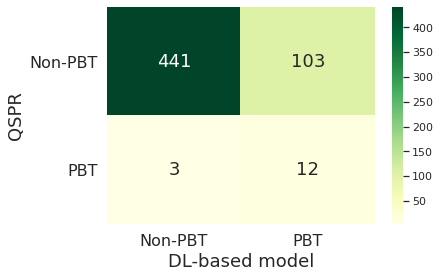

In [164]:
y_true = prediction_pharmadf['QSAR_consensus']
y_pred = prediction_pharmadf['PBT_DL_bin_pred']

cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', annot_kws={"size": 18},
            cbar_kws={'shrink': 1, 'orientation': 'vertical'}, ax=ax)

# Define custom labels for the axes
tick_labels = ['Non-PBT', 'PBT']

# Setting the tick labels on both axes
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Rotate the tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Setting the labels and title
ax.set_xlabel('DL-based model', fontsize=18)
ax.set_ylabel('QSPR', fontsize=18)
ax.set_xticklabels(tick_labels, fontsize=16)
ax.set_yticklabels(tick_labels, fontsize=16)
#plt.savefig('images/Fig6_Oct_pharma.png', dpi=600, bbox_inches='tight')

plt.show()

In [165]:
prediction_pharmadf

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0
...,...,...,...,...,...,...
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0
555,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0
557,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0,0


In [166]:
# True Positives are where both y_true and y_pred are 1 
TP_filter = (prediction_pharmadf['QSAR_consensus'] == 1) & (prediction_pharmadf['PBT_DL_bin_pred'] == 1)

# Filter the DataFrame to get only TP cases
TP_cases = prediction_pharmadf[TP_filter]
TP_cases

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
75,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21,0.947178,000050-53-3,Chlorpromazine,1,1
99,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,0.640789,000298-57-7,Cinnarizine,1,1
141,Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl,0.987741,000070-30-4,Hexachlorophene,1,1
160,CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)cc2)CC1)(c1ccc...,0.992947,053179-11-6,Loperamide,1,1
210,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,0.926327,079617-96-2,Sertraline,1,1
233,CN(C)CC/C=C1/c2ccccc2Sc2ccc(Cl)cc21,0.899995,000113-59-7,Chlorprothixene,1,1
235,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,0.957364,000303-49-1,Clomipramine,1,1
306,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,0.830047,000097-18-7,Bithionol,1,1
317,Fc1ccc(C(c2ccc(F)cc2)N2CCN(C/C=C/c3ccccc3)CC2)cc1,0.962296,052468-60-7,Flunarizine,1,1
527,CCN(CC)CCOc1ccc(/C(=C(\Cl)c2ccccc2)c2ccccc2)cc1,0.913366,000911-45-5,Clomiphene,1,1


In [167]:
len(TP_cases)

12

In [168]:
FP_filter = (prediction_pharmadf['QSAR_consensus'] == 0) & (prediction_pharmadf['PBT_DL_bin_pred'] == 1)

FP_cases = prediction_pharmadf[FP_filter]
FP_cases

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
10,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,0.850233,000050-14-6,Ergocalciferol,0,1
14,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,0.804342,000067-97-0,Cholecalciferol,0,1
39,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798130,000076-57-3,Codeine,0,1
40,CN(C)CCC=C1c2ccccc2CCc2ccccc21,0.556854,000050-48-6,Amitriptyline,0,1
41,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590220,000466-99-9,Hydromorphone,0,1
...,...,...,...,...,...,...
524,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743062,000846-46-8,"Androstane-3,17-dione, (5α)-",0,1
531,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932441,001093-58-9,"Androst-4-en-3-one, 4-chloro-17-hydroxy-, (17β)-",0,1
538,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865204,001852-53-5,"Androstane-3,17-diol, (3α,5α,17β)-",0,1
541,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913128,002622-30-2,Carfenazine,0,1


#### False Negative Cases

In [169]:
FN_filter = (prediction_pharmadf['QSAR_consensus'] == 1) & (prediction_pharmadf['PBT_DL_bin_pred'] == 0)

FN_cases = prediction_pharmadf[FN_filter]
FN_cases

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
87,Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1,0.500709,002398-96-1,Tolnaftate,1,0
311,CC(Cc1ccccc1)NCCC(c1ccccc1)c1ccccc1,0.303312,000390-64-7,Prenylamine,1,0
558,OC(=NCC1CCCCN1)c1cc(OCC(F)(F)F)ccc1OCC(F)(F)F,0.170043,054143-55-4,"Benzamide, N-(2-piperidinylmethyl)-2,5-bis(2,2...",1,0


In [170]:
TN_filter = (prediction_pharmadf['QSAR_consensus'] == 0) & (prediction_pharmadf['PBT_DL_bin_pred'] == 0)

TN_cases = prediction_pharmadf[TN_filter]
TN_cases

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0
...,...,...,...,...,...,...
552,CC(N)C12CC3CC(CC(C3)C1)C2,0.493016,013392-28-4,"1-Adamantanemethylamine, α-methyl-",0,0
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0
555,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0


For comparison, **a distinct dataset taken from a study by Howard and Miur was considered. This dataset encompassed 272 chemicals detected in actual environmental media.**

### **Howard and Miur molecules detectd in environmental media**

In [171]:
HM_mol = pd.read_csv('Datasets/pharma_environment.csv', sep =';')
HM_mol

,ID,Molstructure
0,000050-78-2,Acetylsalicylic Acid
1,000051-21-8,Fluorouracil
2,000051-48-9,Synthroid (Thyroxine)
3,000052-53-9,Verapamil SR
4,000052-86-8,Haloperidol
...,...,...
267,000050-33-9,Phenylbutazone
268,000050-36-2,Cocaine
269,000050-48-6,Amitriptyline
270,000050-49-7,Imipramine


#### Molecules TP cases that are in common with molecules detected in environmental media as P, B or T

In [172]:
TP_cases

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
75,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21,0.947178,000050-53-3,Chlorpromazine,1,1
99,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,0.640789,000298-57-7,Cinnarizine,1,1
141,Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl,0.987741,000070-30-4,Hexachlorophene,1,1
160,CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)cc2)CC1)(c1ccc...,0.992947,053179-11-6,Loperamide,1,1
210,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,0.926327,079617-96-2,Sertraline,1,1
233,CN(C)CC/C=C1/c2ccccc2Sc2ccc(Cl)cc21,0.899995,000113-59-7,Chlorprothixene,1,1
235,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,0.957364,000303-49-1,Clomipramine,1,1
306,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,0.830047,000097-18-7,Bithionol,1,1
317,Fc1ccc(C(c2ccc(F)cc2)N2CCN(C/C=C/c3ccccc3)CC2)cc1,0.962296,052468-60-7,Flunarizine,1,1
527,CCN(CC)CCOc1ccc(/C(=C(\Cl)c2ccccc2)c2ccccc2)cc1,0.913366,000911-45-5,Clomiphene,1,1


In [173]:
# Common molecules between TP and Howard and Miur dataset
common_elements_TP = TP_cases['DB_name'].isin(HM_mol['Molstructure'])

filtered_TP = TP_cases[common_elements_TP]
filtered_TP

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
99,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,0.640789,000298-57-7,Cinnarizine,1,1
210,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,0.926327,079617-96-2,Sertraline,1,1


#### Molecules FP cases that are in common with molecules detected in environmental media as P, B or T

In [174]:
# Common mols between FP and Howard and Miur
common_elements_FP = FP_cases['DB_name'].isin(HM_mol['Molstructure'])

filtered_FP = FP_cases[common_elements_FP]
filtered_FP

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
39,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798130,000076-57-3,Codeine,0,1
40,CN(C)CCC=C1c2ccccc2CCc2ccccc21,0.556854,000050-48-6,Amitriptyline,0,1
71,CN(C)CCCN1c2ccccc2CCc2ccccc21,0.763038,000050-49-7,Imipramine,0,1
79,COc1ccc2c3c1O[C@H]1C(=O)CC[C@@]4(O)[C@@H](C2)N...,0.887851,000076-42-6,Oxycodone,0,1
115,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,0.672074,000058-22-0,Testosterone,0,1
147,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,0.519042,000050-28-2,Estradiol,0,1
155,CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1,0.529471,000437-38-7,Fentanyl,0,1
184,COc1ccc2c3c1O[C@H]1C(=O)CC[C@H]4[C@@H](C2)N(C)...,0.881886,000125-29-1,Hydrocodone,0,1
200,CC12CC3CC(C)(C1)CC(N)(C3)C2,0.929121,019982-08-2,Memantine,0,1
239,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OC)ccc4[C@H]3...,0.897186,000072-33-3,Mestranol,0,1


In [175]:
len(filtered_FP)

12

#### Molecules TN cases that are in common with molecules detected in environmental media as P, B or T

In [176]:
# Common mols between TN and Howard and Miur data
common_elements_TN = TN_cases['DB_name'].isin(HM_mol['Molstructure'])

filtered_TN = TN_cases[common_elements_TN]
filtered_TN

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
18,COCCCC/C(=N\OCCN)c1ccc(C(F)(F)F)cc1,0.024780,054739-18-3,Fluvoxamine,0,0
23,COc1cccc(C2(O)CCCCC2CN(C)C)c1,0.087617,027203-92-5,Tramadol,0,0
24,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,0.457361,000114-07-8,Erythromycin,0,0
26,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...,0.104629,075330-75-5,Lovastatin,0,0
30,Cc1noc(NS(=O)(=O)c2ccc(N)cc2)c1C,0.001842,000127-69-5,Sulfisoxazole,0,0
31,CC=CC(=O)N(CC)c1ccccc1C,0.014243,000483-63-6,Crotamiton,0,0
34,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1,0.156673,093413-69-5,Venlafaxine,0,0
37,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H...,0.471210,000057-27-2,Morphine,0,0
42,CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1,0.507468,000076-99-3,Methadone,0,0
69,O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C...,0.006911,000056-75-7,Chloramphenicol,0,0


In [177]:
len(filtered_TN)

60

### Identification of PBT-related Substructures in Pharmaceuticals

In this section, we will analyze the presence of **13 specific substructures idendified above that are commonly associated with PBT (Persistent, Bioaccumulative, and Toxic) characteristics within the pharmaceutical dataset.** For each substructure, we counted the number of molecules in the dataset that contain the identified substructure, classifying these counts separately for compounds labeled as PBT and non-PBT.

In [178]:
df13_sub['mol'] = df13_sub.apply(lambda x: Chem.MolFromSmiles(x['SMILES']), axis=1)
df13_sub

,SMILES,mol
0,Brc1cccc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7f422f513db0>
1,FC(F)C(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f422f513d50>
2,ClC1:C:C:C:C(Cl):C:1,<rdkit.Chem.rdchem.Mol object at 0x7f422f513bd0>
3,Brc1ccccc1Br,<rdkit.Chem.rdchem.Mol object at 0x7f422f513e10>
4,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7f422f513b70>
5,CC12CCCCC1=CCC1C3CCCC3CCC12,<rdkit.Chem.rdchem.Mol object at 0x7f422f513810>
6,c1cc2ccc3cccc4ccc(c1)c2c34,<rdkit.Chem.rdchem.Mol object at 0x7f422f513cf0>
7,c1ccc2cc3c(ccc4ccccc43)cc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f422f4fe030>
8,c1ccc2c(c1)Cc1ccccc1S2,<rdkit.Chem.rdchem.Mol object at 0x7f422f4fe090>
9,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f422f4fe0f0>


In [179]:
prediction_pharmadf

,DB_smiles,PBT_label,CAS,DB_name,QSAR_consensus,PBT_DL_bin_pred
0,N[C@@H](Cc1c[nH]cn1)C(=O)O,0.000045,000071-00-1,Histidine,0,0
1,N[C@@H](Cc1ccccc1)C(=O)O,0.000155,000063-91-2,Phenylalanine,0,0
2,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,0.000324,000058-85-5,Biotin,0,0
3,NCCCC[C@@H](N)C(=O)O,0.000015,000056-87-1,Lysine,0,0
4,NCCCNCCCCNCCCN,0.000118,000071-44-3,Spermine,0,0
...,...,...,...,...,...,...
554,COc1cc(CC(C)N)cc2c1OCO2,0.004641,013674-05-0,"Phenethylamine, 3-methoxy-α-methyl-4,5-(methyl...",0,0
555,CC(N)C(O)c1ccccc1,0.000931,014838-15-4,"Norephedrine, (.+/-.)-",0,0
556,COc1cc(CC(C)N)c(OC)cc1C,0.027564,015588-95-1,"Benzeneethanamine, 2,5-dimethoxy-α,4-dimethyl-",0,0
557,CNC(C)Cc1ccc2c(c1)OCO2,0.006475,042542-10-9,"N-Methyl-3,4-methylenedioxyamphetamine",0,0


In [180]:
prediction_pharmadf['mol'] = prediction_pharmadf.apply(lambda x: Chem.MolFromSmiles(x['DB_smiles']), axis=1)

### Table 5: List of PBT-relevant substructures identified in the pharmaceutical dataset. 

This code iterates through each substructure in `df13_sub` and identifies matching molecules in the `prediction_pharmadf` dataset. For each substructure:

1. **Find Matches**: Detects which molecules contain the current substructure.
2. **Filter and Count Labels**: Separates matched molecules by their binary `PBT_DL_bin_pred` labels, counting occurrences of `1` (positive) and `0` (negative).
3. **Collect Names**: Lists the names of matched molecules based on their labels.
4. **Display Results**: Outputs the SMILES representation of each substructure, total matches, label counts, and corresponding molecule names.

In [181]:
print("CSs in the Pharma dataset")

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(df13_sub['mol']):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in prediction_pharmadf['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = prediction_pharmadf.iloc[matched_indices]
    
    # Extract PBT_labels and names for matched molecules
    matched_labels = matched_molecules['PBT_DL_bin_pred']
    matched_names = matched_molecules['DB_name']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1
    
    # Collect names for molecules with PBT_label 1 and 0
    names_label_1 = matched_names[matched_labels == 1].tolist()
    names_label_0 = matched_names[matched_labels == 0].tolist()
    
    # Count the total number of substructure matches (highlighted)
    total_matches = len(matched_indices)
    
    # Convert substructure Mol object to SMILES for display
    substructure_name = Chem.MolToSmiles(substructure)
    
    # Print results
    print(f"CS {i}: {substructure_name}")
    print(f"Total matches: {total_matches}")
    print(f"Count of '1' in PBT_label: {count_label_1} | Names: {', '.join(names_label_1)}")
    print(f"Count of '0' in PBT_label: {count_label_0} | Names: {', '.join(names_label_0)}")
    print("-" * 40)

CSs in the Pharma dataset
CS 0: Brc1cccc(Br)c1
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 1: FC(F)C(F)F
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 2: Clc1cccc(Cl)c1
Total matches: 3
Count of '1' in PBT_label: 2 | Names: Hexachlorophene, Bithionol
Count of '0' in PBT_label: 1 | Names: Clonidine
----------------------------------------
CS 3: Brc1ccccc1Br
Total matches: 0
Count of '1' in PBT_label: 0 | Names: 
Count of '0' in PBT_label: 0 | Names: 
----------------------------------------
CS 4: CC12CCCC1C1CCCCC1CC2
Total matches: 34
Count of '1' in PBT_label: 27 | Names: Progesterone, Spironolactone, Betamethasone, Medroxyprogesterone acetate, Triamcinolone, Oxandrolone, Testosterone, Hydrocortamate, Drostanolone, Fluoxymesterone, Budesonide, Dexamethasone, Digitoxin, Testosterone propionate, Bolaste

### Chemprop `interpret` to extract PBT-relevant substructures from pharmaceuticals

Finally, using Chemprop's built-in `interpret`  function, **we extracted PBT-associated substructures from the dataset of pharmaceutical compounds.**

To execute the interpretation run using `chemprop` in a Bash environment:

Open a new bash shell and execute the following commands:

1. **Activate the Conda Environment**  
   First, make sure to activate the `chemprop_DE` Conda environment to access the required dependencies:
   
   ```bash
   conda activate chemprop_DE
   ```

2. Run **Chemprop Interpret** Command


```bash
chemprop_interpret \
    --data_path outputs_pred_interpr/pharma_prediction_DB.csv \
    --features_generator rdkit_2d_normalized \
    --no_features_scaling \
    --min_atoms 4 \
    --checkpoint_dir 0fold_outputs/CC_results_nok/fold_0/ \
    --property_id 1 \
    >> outputs_pred_interpr/new_pharma_interpret_PBT2.log &
```

3. after completing the **Interpret command** in bash returns to this notebook

In [182]:
##Elapsed time = 0:43:53

### Substructure Interpretation Analysis

In the following section, we use the output from the '**interpret**' run (***new_pharma_interpret_PBT.log***) to extract substructures responsible for **PBT** (Persistent, Bioaccumulative, and Toxic) behaviour, . 

**Key findings**:
- **86** substructures were identified as responsible for PBT behavior in at least one compound
- Stereochemistry details were removed from substructures smiles
- Substructures smiles were then canonicalized
- Among these, **10** substructures appeared multiple times
  - The 10 recurring substructures were consolidated into **PBT-related substructures extracted from pharmaceuticals**

In [183]:
pharma_interpr = pd.read_csv('outputs_pred_interpr/new_pharma_interpret_PBT2.log')
pharma_interpr

,smiles,PBT_label,rationale,rationale_score
0,['N[C@@H](Cc1c[nH]cn1)C(=O)O'],0.000,NaN,NaN
1,['N[C@@H](Cc1ccccc1)C(=O)O'],0.000,NaN,NaN
2,['O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21'],0.000,NaN,NaN
3,['NCCCC[C@@H](N)C(=O)O'],0.000,NaN,NaN
4,['NCCCNCCCCNCCCN'],0.000,NaN,NaN
...,...,...,...,...
554,['COc1cc(CC(C)N)cc2c1OCO2'],0.005,NaN,NaN
555,['CC(N)C(O)c1ccccc1'],0.001,NaN,NaN
556,['COc1cc(CC(C)N)c(OC)cc1C'],0.028,NaN,NaN
557,['CNC(C)Cc1ccc2c(c1)OCO2'],0.006,NaN,NaN


In [184]:
# Remove square brackets from SMILES strings
pharma_interpr['smiles'] = pharma_interpr['smiles'].str.strip("['']")
pharma_interpr = pharma_interpr.dropna(subset=['rationale', 'rationale_score'])
# Replace ':1' with '' in the 'substructure' column
pharma_interpr['Substructure'] = pharma_interpr['rationale'].str.replace(':1', '', regex=False)
pharma_interpr

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,smiles,PBT_label,rationale,rationale_score,Substructure
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...
39,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...
41,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...
44,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3]
...,...,...,...,...,...
524,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2
531,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2
538,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2
541,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3]


In [185]:
### In order to find PBT-relevant substructures extracted from the interpretation of pharmaceutical dataset, I will create a new column of Smiles strings by removing  stereochemistry details

In [186]:
# remove stereochemistry details from the substructures column
pharma_interpr['sub_no_stereo'] = pharma_interpr.iloc[:, -1].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
#remove the square brackets [ and ] from the SMILES strings
pharma_interpr['sub_no_stereo'] = pharma_interpr['sub_no_stereo'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
pharma_interpr

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,smiles,PBT_label,rationale,rationale_score,Substructure,sub_no_stereo
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
39,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5
41,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314
44,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3],CN1CCC(c2ccccc2)Sc2ccccc21
...,...,...,...,...,...,...
524,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2
531,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2,CC12CCCCC1=C(Cl)CCC2
538,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2
541,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3],CN1c2ccccc2Sc2ccccc21


In [187]:
pharma_interpr['mol'] = pharma_interpr.apply(lambda x: Chem.MolFromSmiles(x['sub_no_stereo']), axis=1)

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
pharma_interpr['canonical_smi'] = pharma_interpr.apply(lambda x: Chem.MolToSmiles(x['mol']), axis=1)
pharma_interpr

/home/nelse003/miniconda3/envs/pbt_main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,smiles,PBT_label,rationale,rationale_score,Substructure,sub_no_stereo,mol,canonical_smi
10,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.850,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7f422f64a9f0>,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
14,C=C1CC[C@H](O)C/C1=C/C=C1\\CCC[C@]2(C)[C@@H]([...,0.804,C[C@]12CCC/C(=C\C=C3\C[CH2:1]CC[CH2:1]3)[C@@H]...,0.518,C[C@]12CCC/C(=C\C=C3\C[CH2]CC[CH2]3)[C@@H]1CC[...,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7f4228137e10>,CC1CCC2C(=CC=C3CCCCC3)CCCC12C
39,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,0.798,C1=C[CH2:1][C@@H]2Oc3c4c(cc[cH:1]3)C[C@@H]3[C@...,0.765,C1=C[CH2][C@@H]2Oc3c4c(cc[cH]3)C[C@@H]3[C@H]1[...,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5,<rdkit.Chem.rdchem.Mol object at 0x7f422f64a2d0>,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5
41,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,0.590,c1c[cH:1]c2c3c1C[C@@H]1[C@@H]4CC[CH2:1][C@H](O...,0.877,c1c[cH]c2c3c1C[C@@H]1[C@@H]4CC[CH2][C@H](O2)[C...,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314,<rdkit.Chem.rdchem.Mol object at 0x7f422f512cf0>,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314
44,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,0.792,c1ccc2c(c1)S[C@@H](c1cc[cH:1]cc1)[CH2:1][CH2:1...,0.574,c1ccc2c(c1)S[C@@H](c1cc[cH]cc1)[CH2][CH2]N2[CH3],CN1CCC(c2ccccc2)Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f422f66a5d0>,CN1CCC(c2ccccc2)Sc2ccccc21
...,...,...,...,...,...,...,...,...
524,CC12CCC3C(CC[C@@H]4CC(=O)CCC34C)C1CCC2=O,0.743,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7f422f67f810>,CC12CCCC1C1CCCCC1CC2
531,CC12CCC(=O)C(Cl)=C1CCC1C2CCC2(C)C1CC[C@H]2O,0.932,CC12CC[CH2:1]C(Cl)=C1CC[CH2:1][CH2:1]2,0.702,CC12CC[CH2]C(Cl)=C1CC[CH2][CH2]2,CC12CCCCC1=C(Cl)CCC2,<rdkit.Chem.rdchem.Mol object at 0x7f422f67f870>,CC12CCCCC1=C(Cl)CCC2
538,CC12CC[C@H](O)C[C@H]1CCC1C2CCC2(C)C1CC[C@H]2O,0.865,CC12CCC3C(CC[CH2:1][CH2:1]3)C1CC[CH2:1]2,0.570,CC12CCC3C(CC[CH2][CH2]3)C1CC[CH2]2,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7f422f67f8d0>,CC12CCCC1C1CCCCC1CC2
541,CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2,0.913,c1ccc2c(c1)Sc1cc[cH:1]cc1N2[CH3:1],0.685,c1ccc2c(c1)Sc1cc[cH]cc1N2[CH3],CN1c2ccccc2Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f422f67f930>,CN1c2ccccc2Sc2ccccc21


In [189]:
counts = dict(pharma_interpr['canonical_smi'].value_counts())
vals = {k:v for k,v in counts.items() if v>=2}
vals

{'CC12CCCC1C1CCCCC1CC2': 16,
 'CN1c2ccccc2Sc2ccccc21': 13,
 'c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314': 9,
 'C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5': 4,
 'FC12CCCCC1CCCC2': 4,
 'c1ccc2c(c1)CC1NCCC23CCCCC13': 3,
 'CC1CCC2C(=CC=C3CCCCC3)CCCC12C': 2,
 'CC1CCC2C3CCC=CC3CCC12C': 2,
 'c1ccc2c(c1)Cc1ccccc1S2': 2,
 'CC1CCC2C1CCC1CCCCC12': 2}

In [190]:
len(vals)

10

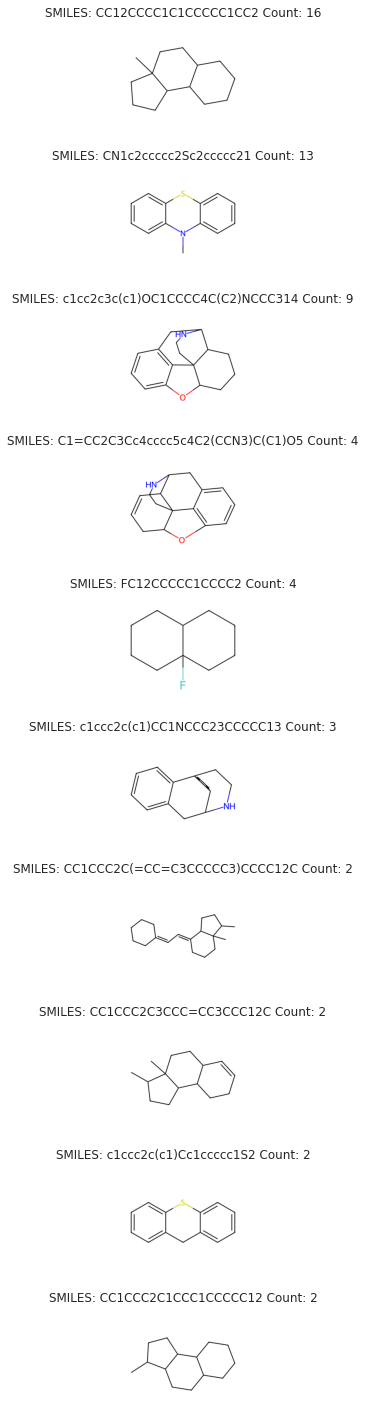

In [191]:
# Create a list of molecule objects from SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in vals.keys()]

# Setting up the plot
fig, axes = plt.subplots(nrows=len(mols), figsize=(10, len(mols) * 2))

# If there is only one molecule, we need to ensure axes is iterable
if len(mols) == 1:
    axes = [axes]

# Draw each molecule with its SMILE and count
for ax, mol, (smiles, count) in zip(axes, mols, vals.items()):
    img = Draw.MolToImage(mol, size=(300, 300))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'SMILES: {smiles} Count: {count}')

plt.tight_layout()
plt.show()

In [192]:
# Create lists for DataFrame  Substructures pharmaceuticals construction
smiles_list = list(vals.keys())
mol_objects = [Chem.MolFromSmiles(sm) for sm in smiles_list]
counts_list = list(vals.values())

# Create the DataFrame
sub_interpret_pharma = pd.DataFrame({
    'smiles_substructures': smiles_list,
    'mol': mol_objects,
    'Count': counts_list
})

sub_interpret_pharma

,smiles_substructures,mol,Count
0,CC12CCCC1C1CCCCC1CC2,<rdkit.Chem.rdchem.Mol object at 0x7f42017a2750>,16
1,CN1c2ccccc2Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x7f422843f9f0>,13
2,c1cc2c3c(c1)OC1CCCC4C(C2)NCCC314,<rdkit.Chem.rdchem.Mol object at 0x7f422843fed0>,9
3,C1=CC2C3Cc4cccc5c4C2(CCN3)C(C1)O5,<rdkit.Chem.rdchem.Mol object at 0x7f422f90aa50>,4
4,FC12CCCCC1CCCC2,<rdkit.Chem.rdchem.Mol object at 0x7f42019447b0>,4
5,c1ccc2c(c1)CC1NCCC23CCCCC13,<rdkit.Chem.rdchem.Mol object at 0x7f422f526c30>,3
6,CC1CCC2C(=CC=C3CCCCC3)CCCC12C,<rdkit.Chem.rdchem.Mol object at 0x7f422f5263f0>,2
7,CC1CCC2C3CCC=CC3CCC12C,<rdkit.Chem.rdchem.Mol object at 0x7f422f526930>,2
8,c1ccc2c(c1)Cc1ccccc1S2,<rdkit.Chem.rdchem.Mol object at 0x7f422f526ab0>,2
9,CC1CCC2C1CCC1CCCCC12,<rdkit.Chem.rdchem.Mol object at 0x7f422f5260f0>,2


### Table S4: PBT-relevant substructures from pharmaceuticals.



The following code analyzes each substructure in `sub_interpret_pharma` by identifying matching molecules in `prediction_pharmadf` and gathering label statistics. Here’s a brief overview:

1. **Match Substructures**: For each substructure, find molecules in `prediction_pharmadf` that contain it.
2. **Filter and Count Labels**: For matched molecules, count the occurrences of `PBT_DL_bin_pred` label `1` (positive) and `0` (negative).
3. **Collect Names with Positive Labels**: Gather names of molecules with a label of `1` and store them in a list.
4. **Display Results**: For each substructure, print its SMILES representation, total matches, counts of labels, and names of molecules with a positive label.

In [193]:
print("Substructures interpret pharma in the pharmaceutical dataset")

molecules_with_label_1 = []

# Iterate through each substructure and perform the analysis
for i, substructure in enumerate(sub_interpret_pharma['mol']):
    # Find matches for the current substructure in the dataset
    highlight_lists = [mol.GetSubstructMatch(substructure) for mol in prediction_pharmadf['mol']]
    
    # Filter matched molecules
    matched_indices = [i for i, match in enumerate(highlight_lists) if match]
    matched_molecules = prediction_pharmadf.iloc[matched_indices]

    # Extract PBT_labels and names for matched molecules
    matched_labels = matched_molecules['PBT_DL_bin_pred']
    matched_names = matched_molecules['DB_name']
    
    # Count occurrences of 1 and 0 in PBT_labels
    count_label_1 = sum(matched_labels)
    count_label_0 = len(matched_labels) - count_label_1

    # Collect names for molecules with PBT_label 1
    names_label_1 = matched_names[matched_labels == 1].tolist()
    molecules_with_label_1.extend(names_label_1)  # Extend the list with new findings
    
    # Print results for verification
    print(f"PC {i}: {Chem.MolToSmiles(substructure)}")
    print(f"Total matches: {len(matched_indices)}")
    print(f"Count of '1' in PBT_label: {count_label_1}")
    print(f"Count of '0' in PBT_label: {count_label_0}")
    print(f"Names with 'PBT_label' = 1: {', '.join(names_label_1)}")
    print("-" * 40)

Substructures interpret pharma in the pharmaceutical dataset
PC 0: CC12CCCC1C1CCCCC1CC2
Total matches: 34
Count of '1' in PBT_label: 27
Count of '0' in PBT_label: 7
Names with 'PBT_label' = 1: Progesterone, Spironolactone, Betamethasone, Medroxyprogesterone acetate, Triamcinolone, Oxandrolone, Testosterone, Hydrocortamate, Drostanolone, Fluoxymesterone, Budesonide, Dexamethasone, Digitoxin, Testosterone propionate, Bolasterone, Furazabol, Androstenedione, Calusterone, Stanolone, Oxymetholone, Stanozolol, Finasteride, Cortisone Acetate, 17α-Methyltestosterone, Androstane-3,17-dione, (5α)-, Androst-4-en-3-one, 4-chloro-17-hydroxy-, (17β)-, Androstane-3,17-diol, (3α,5α,17β)-
----------------------------------------
PC 1: CN1c2ccccc2Sc2ccccc21
Total matches: 13
Count of '1' in PBT_label: 13
Count of '0' in PBT_label: 0
Names with 'PBT_label' = 1: Promazine, Chlorpromazine, Propiomazine, Perphenazine, Acetophenazine, Promethazine, Methotrimeprazine, Periciazine, Acepromazine, Thioproperazin

In the following steps we identified **Molecules experimentally detected in environmental media according Howard and Miur** with confirmed PBT positive behavior according to our model prediction.

In [194]:
## dataframe with molecules in the pharmaceutical dataset with a PBT positive behavior
df_label_1 = pd.DataFrame(molecules_with_label_1, columns=['Molecule Name'])
df_label_1

,Molecule Name
0,Progesterone
1,Spironolactone
2,Betamethasone
3,Medroxyprogesterone acetate
4,Triamcinolone
...,...
92,Oxymetholone
93,Stanozolol
94,Finasteride
95,Cortisone Acetate


In [195]:
## Find molecules with a positive PBT behavior in common with Howar and Miur dataset
common_pharmainterp = df_label_1['Molecule Name'].isin(HM_mol['Molstructure'])
common_ph = df_label_1[common_pharmainterp]
common_ph

,Molecule Name
6,Testosterone
16,Androstenedione
41,Oxycodone
44,Hydrocodone
51,Codeine
61,Oxycodone
67,Hydrocodone
